In [1]:
import os
import subprocess
import torch
import re
os.chdir('../')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

from IPython.display import HTML as html_print
from research.utils import load_vocabulary, Tokenizer, Aligner, RelaxedTargetField, OneHotEncoder, bleu
from research.scorer import Scorer
from research.greedy_optimizer import GreedyOptimizer
from research.beam_optimizer import BeamOptimizer
from research.continuous_optimizer import ContinuousOptimizer

### Model loading

In [2]:
vocab = load_vocabulary()
tokenizer = Tokenizer()
scorer = Scorer()
one_hot_encoder = OneHotEncoder(vocab)

### Translation scoring

In [3]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
german_translation_from_google = 'Ich denke, dass maschinelle Übersetzung ein sehr interessantes Thema ist.'
score = scorer.score_texts(english_sentence, german_translation_from_google)
print('Translation scoring')
print('English sentence:', english_sentence)
print('Translation from google translate to score:', german_translation_from_google)
print('Log likehood of translation:', score[0])

Translation scoring
English sentence: I think, that machine translation is a very interesting subject.
Translation from google translate to score: Ich denke, dass maschinelle Übersetzung ein sehr interessantes Thema ist.
Log likehood of translation: -6.253188


### Predicting of next word in translation

In [4]:
unfinished_translation = 'Ich denke, dass maschinelle Übersetzung ein sehr'
english_tokens = tokenizer.tokenize(english_sentence)
german_tokens = tokenizer.tokenize(unfinished_translation)
next_word_probs = scorer.next_word_probabilities([english_tokens], [german_tokens])
val, ind = next_word_probs.topk(3)
print('English sentence:', english_sentence)
print('Unfinished translation:', unfinished_translation )
print('Top 3 next tokens: ', vocab.itos[ind[0,0].view(-1)], vocab.itos[ind[0,1].view(-1)], vocab.itos[ind[0,2].view(-1)])

English sentence: I think, that machine translation is a very interesting subject.
Unfinished translation: Ich denke, dass maschinelle Übersetzung ein sehr
Top 3 next tokens:  ▁interessante ▁interessant ▁Interessant


### Greedy optimization

In [5]:
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = GreedyOptimizer(english_sentence)
print('Optimizer initialized...')
german_tokens = optimizer.optimize()[:-1]
score = scorer.score_tokenized_texts([english_tokens], [german_tokens])[0]
print('English sentence:', english_sentence)
print('Translated tokens', ' '.join(german_tokens))
print(f'Log likehood of translation: {score:.2f}')

Optimizer initialized...
English sentence: I think, that machine translation is a very interesting subject.
Translated tokens ▁Ich ▁denke , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist .
Log likehood of translation: -5.41


### Beam search optimization

In [6]:
n_beams = 15
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I think, that machine translation is a very interesting subject.
Top 15 translations:
1. ▁Ich ▁denke , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -5.41]
2. ▁Ich ▁glaube , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -5.74]
3. ▁Ich ▁halte ▁die ▁ maschine lle ▁Übersetzung ▁für ▁ein ▁sehr ▁interessante s ▁Thema . [p = -5.77]
4. ▁Ich ▁denke , ▁dass ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.25]
5. ▁Ich ▁glaube , ▁dass ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.65]
6. ▁Ich ▁finde , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.70]
7. ▁Ich ▁denke , ▁die ▁ maschine lle ▁Übersetzung ▁ist ▁ein ▁sehr ▁interessante s ▁Thema . [p = -6.87]
8. ▁Meine s ▁Era chtens ▁ist ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema . [p = -7.14]
9. ▁Ich ▁denke , ▁da

### Entropy of conditional probabilities for each word in different translations

In [7]:
def plot_entropies(i):
    plt.title('Entropy for each word in different translations')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    trans = translations[i][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    words = list(range(probs.shape[0]))
    entropies = [entropy(probs[k, :]) for k in words]
    plt.scatter(words, entropies, label=f'Translation {i}')
    print(f'Translation {i}:\n{" | ".join(trans)}')
    print()
    plt.legend()

def plot_aligned_entropies(i, j):
    plt.title('Entropy for each word in different translations (aligned)')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    
    aligner = Aligner()
    trans_i = translations[i][:-1]
    trans_j = translations[j][:-1]
    aligned_i, aligned_j = aligner.align(trans_i, trans_j)
    
    logprobs_i = scorer.score_probabilities_for_each_word(english_tokens, trans_i)
    probs_i = np.exp(logprobs_i)
    logprobs_j = scorer.score_probabilities_for_each_word(english_tokens, trans_j)
    probs_j = np.exp(logprobs_j)

    words = np.arange(len(aligned_i))
    entropies_i = []
    k = 0
    for word in aligned_i:
        if word == '[PLACEHOLDER]':
            entropies_i += [-1.]
        else:
            entropies_i += [entropy(probs_i[k, :])]
            k += 1
    entropies_i = np.array(entropies_i)
    
    entropies_j = []
    k = 0
    for word in aligned_j:
        if word == '[PLACEHOLDER]':
            entropies_j += [-1.]
        else:
            entropies_j += [entropy(probs_j[k, :])]
            k += 1
    entropies_j = np.array(entropies_j)
    
    plt.scatter(words[entropies_i >= 0.], entropies_i[entropies_i >= 0.], label=f'Translation {i}')
    plt.scatter(words[entropies_j >= 0.], entropies_j[entropies_j >= 0.], label=f'Translation {j}')
    print(f'Translation {i}:\n{" | ".join(aligned_i)}')
    print(f'Translation {j}:\n{" | ".join(aligned_j)}')
    print()
    plt.legend()
    
def plot_maxs(i):
    plt.title('Max for each word in different translations')
    plt.xlabel('Word number')
    plt.ylabel('Max')
    trans = translations[i][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    words = list(range(probs.shape[0]))
    entropies = [np.max(probs[k, :]) for k in words]
    plt.scatter(words, entropies, label=f'Translation {i}')
    print(f'Translation {i}:\n{" | ".join(trans)}')
    print()
    plt.legend()
    
def other_candidates(trans_idx, pos, N = 4):
    trans = translations[trans_idx][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    other_good_choices = np.argsort(probs[pos])[:-6:-1]
    print('Best candidates on position', pos, ': ', ' '.join([vocab.itos[idx] for idx in other_good_choices]))
    print('Coresponding probabilities:', [probs[pos][idx] for idx in other_good_choices])    

#### Comparison of the best and the worst translation

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .

Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



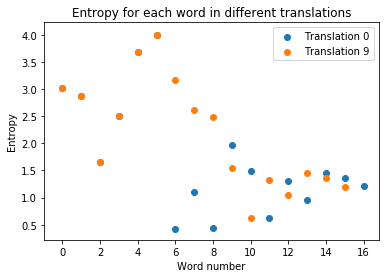

In [8]:
for i in [0, 9]:
    plot_entropies(i)
plt.show()

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .

Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



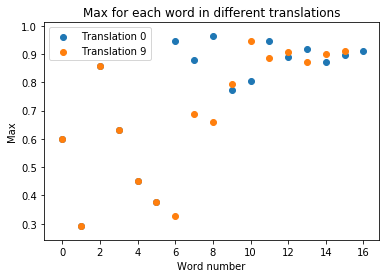

In [9]:
for i in [0, 9]:
    plot_maxs(i)
plt.show()

Entropia z jakiegoś powodu jest bardzo słabą miarą (chyba, że bug). Entropia dla pozycji 0 w zdaniu 9 niewiele różni się od entropi na pozycji 1 w zdaniu 9, a te rozkłady są zupełnie różne (na pozycji 0 mamy tylko 1 prawdopodobną wartość, a na pozycji 1 aż 4). Przykład poniżej:

#### Entropies of alligned sentences

Best vs worst translation:

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | [PLACEHOLDER] | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



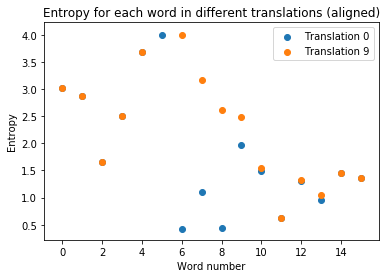

In [11]:
plot_aligned_entropies(0, 9)

Beam-10 vs Greedy translation:

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 3:
▁Ich | ▁denke | , | ▁dass | [PLACEHOLDER] | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



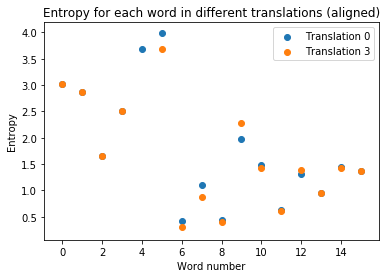

In [12]:
plot_aligned_entropies(0, 3)

Similar translations:

Translation 3:
▁Ich | ▁denke | , | ▁dass | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 4:
▁Ich | ▁glaube | , | ▁dass | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



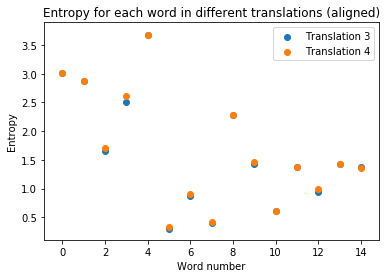

In [13]:
plot_aligned_entropies(3, 4)

In [14]:
other_candidates(9, 0)

Best candidates on position 0 :  ▁Ich ▁Das ▁Die ▁Meiner ▁Meine
Coresponding probabilities: [0.5988918, 0.060954917, 0.036728892, 0.024799734, 0.024179423]


In [152]:
other_candidates(9, 1)

Best candidates on position 1 :  ▁denke ▁glaube ▁halte ▁finde ▁bin
Coresponding probabilities: [0.29839528, 0.25234625, 0.13621552, 0.10573821, 0.043860655]


Zwróćmy też uwagę na niejednoznaczność tokenów: w miejscu, w którym wybieramy token _ prawdopodobieństwo jest małe, oraz entropia duża. Wynika to najprawdopodobniej z tego, że zamiast wybrać token _ , możemy wybrać cały token _ machinelle

### Other probable candidates

In [154]:
other_candidates(3, 1)

Best candidates on position 1 :  ▁denke ▁glaube ▁halte ▁finde ▁bin
Coresponding probabilities: [0.29839528, 0.25234625, 0.13621552, 0.10573821, 0.043860655]


In [153]:
other_candidates(3, 4)

Best candidates on position 4 :  ▁die ▁ ▁das ▁Maschinen ▁eine
Coresponding probabilities: [0.4021218, 0.112477794, 0.079811126, 0.05037697, 0.028617628]


In [155]:
other_candidates(3, 5)

Best candidates on position 5 :  ▁ ▁Übersetzung ▁Maschinen ▁technische ▁Maschinenbau
Coresponding probabilities: [0.4092544, 0.16365328, 0.06526854, 0.013711214, 0.0103740515]


In [156]:
other_candidates(3, 12)

Best candidates on position 12 :  . ▁Thema ▁Themen ▁Gegenstand ▁Subjekt
Coresponding probabilities: [0.45098555, 0.357347, 0.021454206, 0.005650598, 0.0052555017]


In [9]:
other_candidates(0, 5)

Best candidates on position 5 :  lle llen ll ller elle
Coresponding probabilities: [0.89663786, 0.026253838, 0.022556117, 0.012132816, 0.004152786]


In [15]:
other_candidates(0, 0)

Best candidates on position 0 :  ▁Ich ▁Das ▁Die ▁Meiner ▁Meine
Coresponding probabilities: [0.5988918, 0.060954917, 0.036728892, 0.024799734, 0.024179423]


### More difficult sentences:

In [3]:
n_beams = 30
english_sentence = 'Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.'
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.
Top 30 translations:
1. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁ihnen . [p = -11.66]
2. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁ihnen . [p = -11.69]
3. ▁Kinder ▁lieben ▁ihre ▁Eltern ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁sie . [p = -11.72]
4. ▁Kinder ▁beginnen , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁ihnen . [p = -11.73]
5. ▁Kinder ▁beginnen , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁ihnen . [p = -11.83]
6. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁liebe

In [4]:
n_beams = 1
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.
Top 1 translations:
1. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁sie ▁ihnen . [p = -11.85]
Sanity check: log likehood of the best translation = -11.85


In [7]:
n_beams = 30
english_sentence = "There is always something ridiculous about the emotions of people whom one has ceased to love."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: There is always something ridiculous about the emotions of people whom one has ceased to love.
Top 30 translations:
1. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -8.88]
2. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.00]
3. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.06]
4. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.08]
5. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁zu ▁lieben . [p = -9.32]
6. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Gefühl e ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.35]
7. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich

In [6]:
n_beams = 1
english_sentence = "There is always something ridiculous about the emotions of people whom one has ceased to love."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: There is always something ridiculous about the emotions of people whom one has ceased to love.
Top 1 translations:
1. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁nicht ▁mehr ▁lieben . [p = -9.60]
Sanity check: log likehood of the best translation = -9.60


In [3]:
n_beams = 10
english_sentence = "I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self.
Top 10 translations:
1. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.36]
2. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁er , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.37]
3. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der j en ige , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.54]
4. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et , ▁als ▁den , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.68]
5. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁er , ▁der ▁sei

In [8]:
n_beams = 1
english_sentence = "I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self.
Top 1 translations:
1. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der j en ige , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.54]
Sanity check: log likehood of the best translation = -9.54


### Continuous optimization

#### Uniform initialization

In [36]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
english_tok = tokenizer.tokenize(english_sentence)
optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize()
print(res)

Optimization starts...
Score at step  0 = tensor([24.4894], grad_fn=<NegBackward>) max grad component =  lr =  99.0
Score at step  1 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  59.4
Score at step  2 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  35.64
Score at step  3 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  21.384
Score at step  4 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  12.8304
Score at step  5 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  7.698239999999999
Score at step  6 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.618943999999999
Score at step  7 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.7713663999999993
Score at step  8 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0

Score at step  67 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.3544686900010173e-13
Score at step  68 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.126812140006103e-14
Score at step  69 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.876087284003662e-14
Score at step  70 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.925652370402197e-14
Score at step  71 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.7553914222413183e-14
Score at step  72 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.053234853344791e-14
Score at step  73 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.319409120068745e-15
Score at step  74 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.791645472041247e-1

Score at step  134 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.853116598174821e-28
Score at step  135 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.1118699589048926e-28
Score at step  136 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.671219753429356e-29
Score at step  137 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.0027318520576135e-29
Score at step  138 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.401639111234568e-29
Score at step  139 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.4409834667407408e-29
Score at step  140 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.645900800444445e-30
Score at step  141 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.187540480

Score at step  200 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.225569715739044e-43
Score at step  201 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.535341829443426e-43
Score at step  202 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.5212050976660558e-43
Score at step  203 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  9.127230585996333e-44
Score at step  204 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.476338351597799e-44
Score at step  205 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.2858030109586797e-44
Score at step  206 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.9714818065752077e-44
Score at step  207 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.182889083

Score at step  266 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  9.635356695934406e-58
Score at step  267 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.7812140175606435e-58
Score at step  268 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.468728410536386e-58
Score at step  269 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.0812370463218313e-58
Score at step  270 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.2487422277930988e-58
Score at step  271 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  7.492453366758592e-59
Score at step  272 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.495472020055155e-59
Score at step  273 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.697283212

Score at step  331 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.661837531322898e-72
Score at step  332 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.1971025187937385e-72
Score at step  333 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.318261511276243e-72
Score at step  334 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  7.909569067657458e-73
Score at step  335 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.7457414405944743e-73
Score at step  336 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.8474448643566843e-73
Score at step  337 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.7084669186140106e-73
Score at step  338 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.02508015

Score at step  397 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.349906202100137e-87
Score at step  398 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.009943721260082e-87
Score at step  399 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.0059662327560493e-87
Score at step  400 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.8035797396536294e-87
Score at step  401 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.0821478437921776e-87
Score at step  402 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.492887062753065e-88
Score at step  403 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.895732237651839e-88
Score at step  404 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.337439342

Score at step  463 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.9039876288198557e-101
Score at step  464 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.1423925772919134e-101
Score at step  465 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.8543554637514805e-102
Score at step  466 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.1126132782508884e-102
Score at step  467 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.467567966950533e-102
Score at step  468 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.4805407801703196e-102
Score at step  469 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.883244681021917e-103
Score at step  470 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.

#### Greedy initialization with one hot vectors

In [31]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = one_hot_encoder.encode(torch.tensor([[[vocab.stoi[tok] for tok in greedy_translation]]]).transpose(0, 2), v=1000.).squeeze().transpose(0, 1)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init)
print(res)

Optimization starts...
Score at step  0 = tensor([0.4511], grad_fn=<NegBackward>) max grad component =  lr =  99.0
Score at step  1 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  59.4
Score at step  2 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  35.64
Score at step  3 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  21.384
Score at step  4 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  12.8304
Score at step  5 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.698239999999999
Score at step  6 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.618943999999999
Score at step  7 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.7713663999999993
Score at step  8 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.6628198399999996
S

Score at step  70 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.925652370402197e-14
Score at step  71 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.7553914222413183e-14
Score at step  72 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.053234853344791e-14
Score at step  73 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.319409120068745e-15
Score at step  74 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.791645472041247e-15
Score at step  75 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.2749872832247482e-15
Score at step  76 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.3649923699348489e-15
Score at step  77 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.189954219609093e-16
Score at step  78 = tensor([0

Score at step  138 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.401639111234568e-29
Score at step  139 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.4409834667407408e-29
Score at step  140 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.645900800444445e-30
Score at step  141 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.187540480266667e-30
Score at step  142 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.11252428816e-30
Score at step  143 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.867514572896e-30
Score at step  144 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.1205087437376e-30
Score at step  145 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.723052462425599e-31
Score at step  146 = tensor([0.4

Score at step  206 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.9714818065752077e-44
Score at step  207 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.1828890839451247e-44
Score at step  208 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.097334503670747e-45
Score at step  209 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.258400702202448e-45
Score at step  210 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.5550404213214687e-45
Score at step  211 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.5330242527928812e-45
Score at step  212 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  9.198145516757287e-46
Score at step  213 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.518887310054372e-46
Score at step  214 =

Score at step  274 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.6183699272198558e-59
Score at step  275 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  9.710219563319135e-60
Score at step  276 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.826131737991481e-60
Score at step  277 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.4956790427948885e-60
Score at step  278 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.097407425676933e-60
Score at step  279 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.2584444554061598e-60
Score at step  280 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.550666732436959e-61
Score at step  281 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.5304000394621755e-61
Score at step  282 =

Score at step  342 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.3285038759142543e-74
Score at step  343 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.971023255485526e-75
Score at step  344 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.782613953291315e-75
Score at step  345 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.869568371974789e-75
Score at step  346 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.7217410231848733e-75
Score at step  347 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.033044613910924e-75
Score at step  348 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.198267683465544e-76
Score at step  349 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.718960610079326e-76
Score at step  350 = t

Score at step  410 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.090555699679305e-89
Score at step  411 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.54333419807583e-90
Score at step  412 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.926000518845498e-90
Score at step  413 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.3556003113072986e-90
Score at step  414 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.4133601867843791e-90
Score at step  415 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.480161120706275e-91
Score at step  416 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.088096672423765e-91
Score at step  417 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.0528580034542586e-91
Score at step  418 = t

Score at step  478 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.952263938895583e-105
Score at step  479 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.37135836333735e-105
Score at step  480 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.2228150180024095e-105
Score at step  481 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.9336890108014457e-105
Score at step  482 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.1602134064808673e-105
Score at step  483 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.961280438885203e-106
Score at step  484 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.1767682633311215e-106
Score at step  485 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.5060609579986726e-106
Score at ste

In [32]:
print('Greedy translation:', greedy_translation)
print('Continuous translation:', res)
print('Score of greedy translation = ' , scorer.score_tokenized_texts([english_tok], [greedy_translation]))
print('Score of continuous translation = ', scorer.score_tokenized_texts([english_tok], [res]))

Greedy translation: ['▁Ich', '▁denke', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist', '.']
Continuous translation: ['▁Ich', '▁denke', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist', '.']
Score of greedy translation =  tensor([-0.4511])
Score of continuous translation =  tensor([-0.4511])


#### Greedy initialization with probabilities

In [34]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:15, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init)
print(res)

Optimization starts...
Score at step  0 = tensor([1.8099], grad_fn=<NegBackward>) max grad component =  lr =  99.0
Score at step  1 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.) lr =  98.01
Score at step  2 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  58.806
Score at step  3 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  35.2836
Score at step  4 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  21.17016
Score at step  5 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  12.702096
Score at step  6 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  7.621257599999999
Score at step  7 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.572754559999999
Score at step  8 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.743

Score at step  68 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.3409240031010065e-13
Score at step  69 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.045544018606039e-14
Score at step  70 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.827326411163623e-14
Score at step  71 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.8963958466981735e-14
Score at step  72 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.737837508018904e-14
Score at step  73 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.0427025048113424e-14
Score at step  74 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.256215028868054e-15
Score at step  75 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.7537290173208325e-15
Scor

Score at step  134 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.0576423869884536e-28
Score at step  135 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.834585432193072e-28
Score at step  136 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.100751259315843e-28
Score at step  137 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.604507555895059e-29
Score at step  138 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.962704533537035e-29
Score at step  139 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.377622720122221e-29
Score at step  140 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.4265736320733325e-29
Score at step  141 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.559441792439995e-3

Score at step  201 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.183314018581651e-43
Score at step  202 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.5099884111489904e-43
Score at step  203 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.5059930466893943e-43
Score at step  204 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  9.035958280136365e-44
Score at step  205 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  5.421574968081819e-44
Score at step  206 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.2529449808490915e-44
Score at step  207 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.9517669885094548e-44
Score at step  208 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.1710601931056727

Score at step  267 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  9.539003128975051e-58
Score at step  268 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  5.72340187738503e-58
Score at step  269 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.434041126431018e-58
Score at step  270 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.060424675858611e-58
Score at step  271 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.2362548055151665e-58
Score at step  272 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  7.417528833090999e-59
Score at step  273 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.450517299854599e-59
Score at step  274 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.670310379912759e-59


Score at step  334 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.305078896163479e-72
Score at step  335 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  7.830473376980874e-73
Score at step  336 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.698284026188524e-73
Score at step  337 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.8189704157131146e-73
Score at step  338 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.6913822494278687e-73
Score at step  339 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.0148293496567212e-73
Score at step  340 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.088976097940327e-74
Score at step  341 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.653385658764196e-

Score at step  401 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.7855439422570933e-87
Score at step  402 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.071326365354256e-87
Score at step  403 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.427958192125536e-88
Score at step  404 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.8567749152753214e-88
Score at step  405 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.3140649491651927e-88
Score at step  406 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.3884389694991155e-88
Score at step  407 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.330633816994693e-89
Score at step  408 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.998380290196815e

Score at step  467 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.0714871454683796e-102
Score at step  468 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.4428922872810275e-102
Score at step  469 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.4657353723686165e-102
Score at step  470 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.794412234211698e-103
Score at step  471 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  5.276647340527019e-103
Score at step  472 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.1659884043162114e-103
Score at step  473 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.8995930425897267e-103
Score at step  474 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.13975582

In [35]:
print('Greedy translation:', greedy_translation)
print('Continuous translation:', res)
print('Score of greedy translation = ' , scorer.score_tokenized_texts([english_tok], [greedy_translation]))
print('Score of continuous translation = ', scorer.score_tokenized_texts([english_tok], [res]))

Greedy translation: ['▁Ich', '▁denke', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist', '.']
Continuous translation: ['▁Ich', '▁halte', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist']
Score of greedy translation =  tensor([-0.4511])
Score of continuous translation =  tensor([-1.6082])


#### Sentence from test set

In [3]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:-1, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init, method='multiplication', verbose=True)
print(res)

Optimization starts...
Step 0 , loss score =  tensor([2.3881], grad_fn=<NegBackward>) max grad component =  lr =  100
	 cscore =  tensor([2.3881], grad_fn=<NegBackward>)
	dscore =  tensor([0.5355])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁würde , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 1 , loss score =  tensor([1.9038], grad_fn=<NegBackward>) max grad component = 0.0 lr =  100
	 cscore =  tensor([1.9038], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 2 , loss score =  tensor([1.6958], grad_fn=<NegBackward>) max grad component = 0.0 lr =  100
	 cscore =  tensor([1.6958], grad_fn=<NegBackward>)
	dscore =  tensor([0.5412])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁will , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁en

Step 24 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  0.01220703125
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 25 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  0.006103515625
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 26 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  0.0030517578125
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁d

	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 47 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  1.4551915228366852e-09
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 48 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  7.275957614183426e-10
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 49 , loss score =  

In [4]:
print('Greedy translation:', ' '.join(greedy_translation))
print('Continuous translation:', ' '.join(res))
print('Score of greedy translation = ' , -scorer.score_tokenized_texts([english_tok], [greedy_translation], method='multiplication', normalize=True))
print('Score of continuous translation = ', -scorer.score_tokenized_texts([english_tok], [res], method='multiplication', normalize=True))

Greedy translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁würde , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "
Continuous translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "
Score of greedy translation =  tensor([0.5355])
Score of continuous translation =  tensor([0.5352])


In [55]:
print('BLEU of greedy: 11.06')
print('BLEU of continuous: 9.67')
print('(measured by multi-bleu.perl script)')

BLEU of greedy: 11.06
BLEU of continuous: 9.67
(measured by multi-bleu.perl script)


In [60]:
n_beams = 10
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimization starts...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tok], [translations[0][:-1]])[0]
print(f'Sanity check: score of the best translation = {score:.2f}')

Optimization starts...
English sentence: But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."
Top 10 translations:
1. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁indem ▁er ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . " [p = -20.19]
2. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁wenn ▁er ▁sagte : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . " [p = -20.32]
3. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁wenn ▁er ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . " [p = -20.34]
4. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁indem ▁er ▁sagt : ▁" Es ▁geht ▁ihm ▁endlich ▁gut . " [p = -20.59]
5. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jem

In [61]:
print('BLEU of beam: 12.98')

BLEU of beam: 12.98


In [ ]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:-1, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init, method='cross_entropy', verbose=True)
print(res)

### Continuous with cross entropy

In [3]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:-1, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init, method='multiplication')
print(res)

KeyboardInterrupt: 

In [5]:
print('Greedy translation:', ' '.join(greedy_translation))
print('Continuous translation:', ' '.join(res))
print('Score of greedy translation = ' , scorer.score_tokenized_texts([english_tok], [greedy_translation]))
print('Score of continuous translation = ', scorer.score_tokenized_texts([english_tok], [res]))

Greedy translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁würde , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "
Continuous translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagte , ▁er ▁könne ▁nicht en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagte : ▁„ Es ▁ging ▁ihm ▁endlich ▁gut . "
Score of greedy translation =  tensor([-0.5355])
Score of continuous translation =  tensor([-1.0102])


In [6]:
print('BLEU of continuous translation with cross entropy: 13.46')

BLEU of continuous translation with cross entropy: 13.46


#### Continuous optimization with cross entropy - uniform initialization

In [11]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(method='multiplication', verbose=True)
print(res)

Optimization starts...
0
Step 0 , loss score =  tensor([24.9637], grad_fn=<NegBackward>) max grad component =  lr =  50
	 cscore =  tensor([24.9637], grad_fn=<NegBackward>)


AssertionError: Dataset cannot contain Special Tokens

In [64]:
def plot_aligned_entropies(trans_i, trans_j):
    plt.title('Entropy for each word in different translations (aligned)')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    
    aligner = Aligner()
    aligned_i, aligned_j = aligner.align(trans_i, trans_j)
    
    logprobs_i = scorer.score_probabilities_for_each_word(english_tok, trans_i)
    probs_i = np.exp(logprobs_i)
    logprobs_j = scorer.score_probabilities_for_each_word(english_tok, trans_j)
    probs_j = np.exp(logprobs_j)

    words = np.arange(len(aligned_i))
    entropies_i = []
    k = 0
    for word in aligned_i:
        if word == '[PLACEHOLDER]':
            entropies_i += [-1.]
        else:
            entropies_i += [entropy(probs_i[k, :])]
            k += 1
    entropies_i = np.array(entropies_i)
    
    entropies_j = []
    k = 0
    for word in aligned_j:
        if word == '[PLACEHOLDER]':
            entropies_j += [-1.]
        else:
            entropies_j += [entropy(probs_j[k, :])]
            k += 1
    entropies_j = np.array(entropies_j)
    
    plt.scatter(words[entropies_i >= 0.], entropies_i[entropies_i >= 0.], label=f'Translation 1')
    plt.scatter(words[entropies_j >= 0.], entropies_j[entropies_j >= 0.], label=f'Translation 2')
    print(f'Translation 1:\n{" | ".join(aligned_i)}')
    print(f'Translation 2:\n{" | ".join(aligned_j)}')
    print()
    plt.legend()

Translation 1:
▁Aber | ▁der | ▁Bruder | ▁des | ▁Opfer | s | ▁sagt | , | ▁er | ▁könne | ▁nicht | ▁an | ▁jemand | en | ▁denken | , | ▁der | ▁ihm | ▁we | h | ▁tun | ▁würde | , | ▁indem | ▁er | ▁sagt | : | ▁" | Es | ▁ging | ▁ihm | ▁endlich | ▁gut | . | "
Translation 2:
▁Aber | ▁der | ▁Bruder | ▁des | ▁Opfer | s | ▁sagt | , | ▁er | ▁könne | [PLACEHOLDER] | [PLACEHOLDER] | ▁niemand | en | ▁denken | , | ▁der | [PLACEHOLDER] | ▁ihn | ▁verletz | en | ▁würde | , | [PLACEHOLDER] | ▁und | ▁sagt | : | ▁" | Es | ▁ging | ▁ihm | ▁endlich | ▁gut | . | "



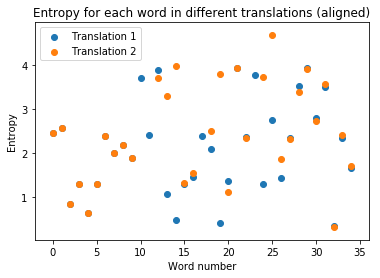

In [66]:
plot_aligned_entropies(translations[0][:-1], greedy_translation, )

### Continuous with multiplication - more examples

In [3]:
WMT_DIR = '/home/pma/wmt/'
german_path = WMT_DIR + 'test.de'
english_path = WMT_DIR + 'test.en'

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def load_test_data(path):
    with open(path) as f:
        return [tokenizer.detokenize(line.split()) for line in f.readlines()]

def load_reference_data(path):
    with open(path) as f:
        return [line.strip() for line in f.readlines()]
    
def perform_tests(k=50, initialization='greedy', beamsize=15, temperature=1.):
    aligner = Aligner()
    scorer = Scorer(temperature=temperature)
    english_sentences = load_test_data(english_path)
    references = load_reference_data(german_path)
    better_score_cnt = 0
    no_change_score_cnt = 0
    worse_score_cnt = 0
    better_bleu_cnt = 0
    no_change_bleu_cnt = 0
    worse_bleu_cnt = 0
    bleu_before_sum = 0
    bleu_after_sum = 0
    score_before_sum = 0
    score_after_sum = 0
    for english_sentence, reference in zip(english_sentences[:k], references):
        english_tok = tokenizer.tokenize(english_sentence)
        if initialization == 'greedy':
            greedy_optimizer = GreedyOptimizer(english_sentence, temperature=temperature)
            greedy_translation = greedy_optimizer.optimize()[:-1]
        else:
            greedy_optimizer = BeamOptimizer(english_sentence, beamsize, temperature=temperature)
            greedy_translation = greedy_optimizer.optimize()[0][0][:-1]
        
        greedy_score = -scorer.score_tokenized_texts([english_tok], [greedy_translation], method='multiplication', normalize=True)
        gbleu = bleu(reference, ' '.join(greedy_translation))

        greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
        greedy_init = torch.tensor(greedy_init[:-1, :].T)
        print(greedy_init.shape)
        print(greedy_init)
        maxes = torch.max(greedy_init, 0)[0]
        print(maxes.shape)
        print(maxes)
        
        continuous_optimizer = ContinuousOptimizer(english_sentence, temperature=temperature)
        continuous_translation, cscore = continuous_optimizer.optimize(init=greedy_init, method='multiplication', with_score=True, start_lr=100)
        dscore = -scorer.score_tokenized_texts([english_tok], [continuous_translation], method='multiplication', normalize=True)
        cbleu = bleu(reference, ' '.join(continuous_translation))

        aligned_greedy, aligned_continuous = aligner.align(greedy_translation, continuous_translation)
        
        colored_continuous = [cstr(cword, color='black') if gword == cword else cstr(cword, color='green') 
            for gword, cword in zip(aligned_greedy, aligned_continuous)]
        colored_continuous.append(cstr(f'[ cscore={cscore.item()}, dscore={dscore.item()}, bleu={cbleu} ]', color='black'))
        
        display(html_print(cstr(' '.join(aligned_greedy) + f'[ dscore={greedy_score.item()}, bleu={gbleu} ]', color='black')))
        display(html_print(' '.join(colored_continuous)))
        display(html_print('<br>'))
        
        if dscore < greedy_score:
            better_score_cnt += 1
        if dscore == greedy_score:
            no_change_score_cnt += 1
        if dscore > greedy_score:
            worse_score_cnt += 1
        
        if cbleu > gbleu:
            better_bleu_cnt += 1
        if cbleu == gbleu:
            no_change_bleu_cnt += 1
        if cbleu < gbleu:
            worse_bleu_cnt += 1
            
        bleu_before_sum += gbleu
        bleu_after_sum += cbleu
        score_before_sum += greedy_score
        score_after_sum += dscore
        
    
    better_score_percent = 100 * better_score_cnt / float(k)
    no_change_score_percent = 100 * no_change_score_cnt / float(k)
    worse_score_percent = 100 * worse_score_cnt / float(k)
    better_bleu_percent = 100 * better_bleu_cnt / float(k)
    no_change_bleu_percent = 100 * no_change_bleu_cnt / float(k)
    worse_bleu_percent = 100 * worse_bleu_cnt / float(k)
    avg_bleu_before = bleu_before_sum / float(k)
    avg_bleu_after = bleu_after_sum / float(k)
    avg_dscore_before = score_before_sum.item() / float(k)
    avg_dscore_after = score_after_sum.item() / float(k)
    
    print(f'Total statistics (tested on {k} sentences)')
    print(f'{better_score_cnt} sentences with better score ({better_score_percent}%)')
    print(f'{no_change_score_cnt} sentences without change in score ({no_change_score_percent}%)')
    print(f'{worse_score_cnt} sentences with worse score ({worse_score_percent}%)')
    print(f'{better_bleu_cnt} sentences with better bleu ({better_bleu_percent}%)')
    print(f'{no_change_bleu_cnt} sentences without change in bleu ({no_change_bleu_percent}%)')
    print(f'{worse_bleu_percent} sentences with worse bleu ({worse_bleu_percent}%)')
    print(f'Average BLEU before continuous optimization: {avg_bleu_before}')
    print(f'Average BLEU after continuous optimization: {avg_bleu_after}')
    print(f'Average dscore before continuous optimization: {avg_dscore_before}')
    print(f'Average dscore after continuous optimization: {avg_dscore_after}')
    
    

def compare_beam_greedy(k, n_beams=10):
    aligner = Aligner()
    scorer = Scorer()
    english_sentences = load_test_data(english_path)
    references = load_reference_data(german_path)
    english_sentence = english_sentences[k]
    print(english_sentence)
    english_tok = tokenizer.tokenize(english_sentence)
    reference = references[k]
    greedy_optimizer = GreedyOptimizer(english_sentence)
    greedy_translation = greedy_optimizer.optimize()[:-1]
    
    greedy_score = -scorer.score_tokenized_texts([english_tok], [greedy_translation])
    gbleu = bleu(reference, ' '.join(greedy_translation))
    
    display(html_print(cstr('Greedy: ' + ' '.join(greedy_translation), color='black')))
    display(html_print(cstr(f'greedy dscore = {greedy_score}, greedy bleu = {gbleu}', color='black')))
    display(html_print('<br>'))


    beam_optimizer = BeamOptimizer(english_sentence, n_beams = n_beams)
    beam_translations = beam_optimizer.optimize()
    print(beam_translations)
    beam_translation = beam_translations[0][0][:-1]
    display(html_print(cstr('Beam: ' + ' '.join(beam_translation), color='black')))
    beam_score = -scorer.score_tokenized_texts([english_tok], [beam_translation])
    #bbleu = bleu(reference, ' '.join(beam_translation))
    
    greedy_translation_aligned, beam_translation_aligned = aligner.align(greedy_translation, beam_translation)
    colored_translation = [cstr(gword, color='black') if gword == bword else cstr(bword, color='green') 
        for gword, bword in zip(greedy_translation_aligned, beam_translation_aligned)] 
    
    display(html_print(cstr(f'beam dscore = {beam_score}, beam bleu = nie dziala...', color='black')))
    display(html_print(' '.join(colored_translation)))
    display(html_print('<br>'))
        

def perform_detailed_test(k, initialization='greedy', temperature=1.0):
    aligner = Aligner()
    scorer = Scorer(temperature=temperature)
    english_sentences = load_test_data(english_path)
    references = load_reference_data(german_path)
    english_sentence = english_sentences[k]
    print(english_sentence)
    english_tok = tokenizer.tokenize(english_sentence)
    reference = references[k]
    greedy_optimizer = GreedyOptimizer(english_sentence, temperature=temperature)
    greedy_translation = greedy_optimizer.optimize()[:-1]
    
    greedy_score = -scorer.score_tokenized_texts([english_tok], [greedy_translation], method='multiplication', normalize=True)
    gbleu = bleu(reference, ' '.join(greedy_translation))
    
    display(html_print(cstr('Greedy: ' + ' '.join(greedy_translation), color='black')))
    display(html_print(cstr(f'greedy dscore = {greedy_score}, greedy bleu = {gbleu}', color='black')))
    display(html_print('<br>'))
    display(html_print(cstr('Optimization trace:')))

    greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
    greedy_init = torch.tensor(greedy_init[:-1, :].T)
    continuous_optimizer = ContinuousOptimizer(english_sentence, temperature=temperature)
    trace = continuous_optimizer.optimize_with_trace(init=greedy_init, method='multiplication', start_lr=100)
    prev_translation = None
    prev_dscore = None
    for trace_entry in trace:
        display(html_print(cstr(f'Step {trace_entry["step"]}', color='black')))
        loss_score = trace_entry["loss_score"].item()
        cscore = trace_entry["cscore"].item()
        dscore = trace_entry["dscore"].item()
        if prev_dscore is None or prev_dscore >= dscore:
            display(html_print(cstr(f'\tloss_score = {loss_score}, cscore = {cscore}, dscore = {dscore}', color='black')))
        else:
            display(html_print(cstr(f'\tloss_score = {loss_score}, cscore = {cscore}, ', color='black') + cstr(f'dscore = {dscore}', color='red')))
        prev_dscore = dscore
        
        translation = trace_entry['translation']
        if prev_translation is None:
            display(html_print(cstr('\t' + ' '.join(translation), color='black')))
        else:
            prev_translation_aligned, translation_aligned = aligner.align(prev_translation, translation)
            colored_translation = [cstr(cword, color='black') if pword == cword else cstr(cword, color='green') 
                for pword, cword in zip(prev_translation_aligned, translation_aligned)] 
            
            display(html_print(' '.join(colored_translation)))
            display(html_print('<br>'))
        prev_translation = translation

In [13]:
perform_tests(k=100, initialization='greedy', temperature=1.)

Total statistics (tested on 100 sentences)
6 sentences with better score (6.0%)
54 sentences without change in score (54.0%)
40 sentences with worse score (40.0%)
7 sentences with better bleu (7.0%)
82 sentences without change in bleu (82.0%)
11.0 sentences with worse bleu (11.0%)
Average BLEU before continuous optimization: 29.92579999999999
Average BLEU after continuous optimization: 30.234499999999993
Average dscore before continuous optimization: 0.4621334457397461
Average dscore after continuous optimization: 0.5924079132080078


In [4]:
perform_tests(k=100, initialization='greedy', temperature=100)

torch.Size([31538, 9])
tensor([[-10.3585, -10.3548, -10.3522,  ..., -10.3516, -10.3542, -10.3493],
        [-10.5698, -10.6717, -10.6369,  ..., -10.6855, -10.6915, -10.7206],
        [-10.3585, -10.3548, -10.3522,  ..., -10.3516, -10.3542, -10.3493],
        ...,
        [-10.3586, -10.3547, -10.3522,  ..., -10.3516, -10.3542, -10.3494],
        [-10.3585, -10.3548, -10.3522,  ..., -10.3516, -10.3542, -10.3493],
        [-10.3588, -10.3549, -10.3524,  ..., -10.3517, -10.3543, -10.3498]])


torch.Size([31538, 34])
tensor([[-10.3602, -10.3562, -10.3565,  ..., -10.3538, -10.3522, -10.3583],
        [-10.5470, -10.5848, -10.6072,  ..., -10.6843, -10.7047, -10.5790],
        [-10.3602, -10.3562, -10.3565,  ..., -10.3538, -10.3522, -10.3583],
        ...,
        [-10.3602, -10.3561, -10.3564,  ..., -10.3537, -10.3522, -10.3584],
        [-10.3602, -10.3562, -10.3565,  ..., -10.3538, -10.3522, -10.3583],
        [-10.3604, -10.3563, -10.3564,  ..., -10.3535, -10.3523, -10.3584]])


torch.Size([31538, 31])
tensor([[-10.3584, -10.3566, -10.3532,  ..., -10.3551, -10.3553, -10.3566],
        [-10.5471, -10.6096, -10.6120,  ..., -10.6210, -10.6301, -10.6220],
        [-10.3584, -10.3566, -10.3532,  ..., -10.3551, -10.3553, -10.3566],
        ...,
        [-10.3584, -10.3566, -10.3532,  ..., -10.3550, -10.3553, -10.3566],
        [-10.3584, -10.3566, -10.3532,  ..., -10.3551, -10.3553, -10.3566],
        [-10.3585, -10.3566, -10.3534,  ..., -10.3551, -10.3553, -10.3567]])


torch.Size([31538, 38])
tensor([[-10.3618, -10.3598, -10.3559,  ..., -10.3584, -10.3542, -10.3571],
        [-10.5397, -10.5758, -10.6319,  ..., -10.5649, -10.5856, -10.6564],
        [-10.3618, -10.3598, -10.3559,  ..., -10.3584, -10.3542, -10.3571],
        ...,
        [-10.3618, -10.3597, -10.3558,  ..., -10.3584, -10.3541, -10.3570],
        [-10.3618, -10.3598, -10.3559,  ..., -10.3584, -10.3542, -10.3571],
        [-10.3618, -10.3597, -10.3558,  ..., -10.3584, -10.3540, -10.3571]])


torch.Size([31538, 24])
tensor([[-10.3608, -10.3572, -10.3564,  ..., -10.3564, -10.3524, -10.3579],
        [-10.5538, -10.5841, -10.5990,  ..., -10.5801, -10.6181, -10.5907],
        [-10.3608, -10.3572, -10.3564,  ..., -10.3564, -10.3524, -10.3579],
        ...,
        [-10.3608, -10.3572, -10.3563,  ..., -10.3563, -10.3522, -10.3579],
        [-10.3608, -10.3572, -10.3564,  ..., -10.3564, -10.3524, -10.3579],
        [-10.3609, -10.3572, -10.3563,  ..., -10.3561, -10.3519, -10.3578]])


torch.Size([31538, 59])
tensor([[-10.3586, -10.3540, -10.3565,  ..., -10.3556, -10.3566, -10.3581],
        [-10.5730, -10.6218, -10.5746,  ..., -10.5912, -10.5562, -10.5789],
        [-10.3586, -10.3540, -10.3565,  ..., -10.3556, -10.3566, -10.3581],
        ...,
        [-10.3586, -10.3541, -10.3565,  ..., -10.3556, -10.3566, -10.3582],
        [-10.3586, -10.3540, -10.3565,  ..., -10.3556, -10.3566, -10.3581],
        [-10.3584, -10.3543, -10.3564,  ..., -10.3551, -10.3566, -10.3582]])


torch.Size([31538, 25])
tensor([[-10.3605, -10.3554, -10.3572,  ..., -10.3571, -10.3579, -10.3583],
        [-10.5478, -10.5939, -10.5280,  ..., -10.5798, -10.5472, -10.5836],
        [-10.3605, -10.3554, -10.3572,  ..., -10.3571, -10.3579, -10.3583],
        ...,
        [-10.3605, -10.3553, -10.3571,  ..., -10.3570, -10.3578, -10.3583],
        [-10.3605, -10.3554, -10.3572,  ..., -10.3571, -10.3579, -10.3583],
        [-10.3606, -10.3553, -10.3571,  ..., -10.3570, -10.3578, -10.3583]])


torch.Size([31538, 29])
tensor([[-10.3611, -10.3574, -10.3575,  ..., -10.3537, -10.3570, -10.3572],
        [-10.5498, -10.5996, -10.5334,  ..., -10.5913, -10.5448, -10.6093],
        [-10.3611, -10.3574, -10.3575,  ..., -10.3537, -10.3570, -10.3572],
        ...,
        [-10.3611, -10.3575, -10.3576,  ..., -10.3536, -10.3569, -10.3571],
        [-10.3611, -10.3574, -10.3575,  ..., -10.3537, -10.3570, -10.3572],
        [-10.3612, -10.3575, -10.3576,  ..., -10.3537, -10.3569, -10.3572]])


torch.Size([31538, 19])
tensor([[-10.3598, -10.3568, -10.3584,  ..., -10.3588, -10.3557, -10.3581],
        [-10.5501, -10.6127, -10.5482,  ..., -10.5357, -10.5838, -10.5608],
        [-10.3598, -10.3568, -10.3584,  ..., -10.3588, -10.3557, -10.3581],
        ...,
        [-10.3598, -10.3568, -10.3585,  ..., -10.3588, -10.3558, -10.3581],
        [-10.3598, -10.3568, -10.3584,  ..., -10.3588, -10.3557, -10.3581],
        [-10.3597, -10.3568, -10.3584,  ..., -10.3588, -10.3559, -10.3580]])


torch.Size([31538, 27])
tensor([[-10.3546, -10.3485, -10.3558,  ..., -10.3548, -10.3564, -10.3566],
        [-10.5876, -10.6113, -10.6321,  ..., -10.6081, -10.5853, -10.5982],
        [-10.3546, -10.3485, -10.3558,  ..., -10.3548, -10.3564, -10.3566],
        ...,
        [-10.3546, -10.3485, -10.3558,  ..., -10.3548, -10.3564, -10.3566],
        [-10.3546, -10.3485, -10.3558,  ..., -10.3548, -10.3564, -10.3566],
        [-10.3546, -10.3488, -10.3560,  ..., -10.3549, -10.3564, -10.3566]])


torch.Size([31538, 20])
tensor([[-10.3600, -10.3561, -10.3568,  ..., -10.3565, -10.3536, -10.3572],
        [-10.5530, -10.5951, -10.5909,  ..., -10.6289, -10.5644, -10.6232],
        [-10.3600, -10.3561, -10.3568,  ..., -10.3565, -10.3536, -10.3572],
        ...,
        [-10.3600, -10.3563, -10.3567,  ..., -10.3565, -10.3536, -10.3572],
        [-10.3600, -10.3561, -10.3568,  ..., -10.3565, -10.3536, -10.3572],
        [-10.3601, -10.3564, -10.3567,  ..., -10.3567, -10.3537, -10.3572]])


torch.Size([31538, 20])
tensor([[-10.3573, -10.3489, -10.3562,  ..., -10.3589, -10.3567, -10.3583],
        [-10.5662, -10.6258, -10.6254,  ..., -10.5269, -10.5937, -10.5700],
        [-10.3573, -10.3489, -10.3562,  ..., -10.3589, -10.3567, -10.3583],
        ...,
        [-10.3573, -10.3490, -10.3563,  ..., -10.3589, -10.3568, -10.3584],
        [-10.3573, -10.3489, -10.3562,  ..., -10.3589, -10.3567, -10.3583],
        [-10.3573, -10.3492, -10.3564,  ..., -10.3588, -10.3566, -10.3583]])


torch.Size([31538, 11])
tensor([[-10.3609, -10.3579, -10.3577,  ..., -10.3552, -10.3543, -10.3578],
        [-10.5460, -10.5478, -10.5833,  ..., -10.5798, -10.6063, -10.5923],
        [-10.3609, -10.3579, -10.3577,  ..., -10.3552, -10.3543, -10.3578],
        ...,
        [-10.3609, -10.3580, -10.3577,  ..., -10.3552, -10.3544, -10.3578],
        [-10.3609, -10.3579, -10.3577,  ..., -10.3552, -10.3543, -10.3578],
        [-10.3610, -10.3580, -10.3579,  ..., -10.3553, -10.3543, -10.3578]])


torch.Size([31538, 23])
tensor([[-10.3595, -10.3572, -10.3575,  ..., -10.3499, -10.3570, -10.3577],
        [-10.5431, -10.5873, -10.5847,  ..., -10.6242, -10.5956, -10.5990],
        [-10.3595, -10.3572, -10.3575,  ..., -10.3499, -10.3570, -10.3577],
        ...,
        [-10.3595, -10.3572, -10.3574,  ..., -10.3499, -10.3570, -10.3577],
        [-10.3595, -10.3572, -10.3575,  ..., -10.3499, -10.3570, -10.3577],
        [-10.3595, -10.3573, -10.3573,  ..., -10.3502, -10.3570, -10.3577]])


torch.Size([31538, 15])
tensor([[-10.3599, -10.3578, -10.3580,  ..., -10.3560, -10.3563, -10.3589],
        [-10.5563, -10.5521, -10.5548,  ..., -10.6240, -10.6282, -10.5565],
        [-10.3599, -10.3578, -10.3580,  ..., -10.3560, -10.3563, -10.3589],
        ...,
        [-10.3599, -10.3579, -10.3580,  ..., -10.3559, -10.3564, -10.3589],
        [-10.3599, -10.3578, -10.3580,  ..., -10.3560, -10.3563, -10.3589],
        [-10.3600, -10.3578, -10.3580,  ..., -10.3561, -10.3562, -10.3590]])


torch.Size([31538, 11])
tensor([[-10.3600, -10.3573, -10.3572,  ..., -10.3549, -10.3563, -10.3583],
        [-10.5592, -10.5599, -10.5984,  ..., -10.5812, -10.6525, -10.5936],
        [-10.3600, -10.3573, -10.3572,  ..., -10.3549, -10.3563, -10.3583],
        ...,
        [-10.3600, -10.3573, -10.3572,  ..., -10.3549, -10.3563, -10.3583],
        [-10.3600, -10.3573, -10.3572,  ..., -10.3549, -10.3563, -10.3583],
        [-10.3601, -10.3574, -10.3573,  ..., -10.3551, -10.3563, -10.3583]])


torch.Size([31538, 31])
tensor([[-10.3603, -10.3557, -10.3578,  ..., -10.3560, -10.3573, -10.3573],
        [-10.5579, -10.6235, -10.5492,  ..., -10.6516, -10.6287, -10.5980],
        [-10.3603, -10.3557, -10.3578,  ..., -10.3560, -10.3573, -10.3573],
        ...,
        [-10.3604, -10.3558, -10.3578,  ..., -10.3560, -10.3573, -10.3573],
        [-10.3603, -10.3557, -10.3578,  ..., -10.3560, -10.3573, -10.3573],
        [-10.3605, -10.3559, -10.3580,  ..., -10.3560, -10.3574, -10.3575]])


torch.Size([31538, 30])
tensor([[-10.3597, -10.3568, -10.3566,  ..., -10.3554, -10.3544, -10.3584],
        [-10.5373, -10.5967, -10.6109,  ..., -10.6380, -10.5702, -10.5826],
        [-10.3597, -10.3568, -10.3566,  ..., -10.3554, -10.3544, -10.3584],
        ...,
        [-10.3597, -10.3567, -10.3565,  ..., -10.3553, -10.3543, -10.3584],
        [-10.3597, -10.3568, -10.3566,  ..., -10.3554, -10.3544, -10.3584],
        [-10.3598, -10.3568, -10.3564,  ..., -10.3553, -10.3542, -10.3584]])


torch.Size([31538, 21])
tensor([[-10.3598, -10.3586, -10.3563,  ..., -10.3520, -10.3577, -10.3578],
        [-10.5684, -10.5672, -10.5596,  ..., -10.6140, -10.5620, -10.6030],
        [-10.3598, -10.3586, -10.3563,  ..., -10.3520, -10.3577, -10.3578],
        ...,
        [-10.3599, -10.3586, -10.3564,  ..., -10.3522, -10.3577, -10.3579],
        [-10.3598, -10.3586, -10.3563,  ..., -10.3520, -10.3577, -10.3578],
        [-10.3600, -10.3586, -10.3563,  ..., -10.3520, -10.3576, -10.3579]])


torch.Size([31538, 15])
tensor([[-10.3594, -10.3588, -10.3561,  ..., -10.3564, -10.3569, -10.3586],
        [-10.5550, -10.5511, -10.5381,  ..., -10.6066, -10.5828, -10.5741],
        [-10.3594, -10.3588, -10.3561,  ..., -10.3564, -10.3569, -10.3586],
        ...,
        [-10.3595, -10.3588, -10.3562,  ..., -10.3564, -10.3569, -10.3586],
        [-10.3594, -10.3588, -10.3561,  ..., -10.3564, -10.3569, -10.3586],
        [-10.3596, -10.3587, -10.3561,  ..., -10.3561, -10.3569, -10.3586]])


torch.Size([31538, 14])
tensor([[-10.3585, -10.3569, -10.3573,  ..., -10.3552, -10.3563, -10.3584],
        [-10.5502, -10.5759, -10.5898,  ..., -10.6106, -10.5826, -10.5606],
        [-10.3585, -10.3569, -10.3573,  ..., -10.3552, -10.3563, -10.3584],
        ...,
        [-10.3586, -10.3569, -10.3573,  ..., -10.3551, -10.3563, -10.3584],
        [-10.3585, -10.3569, -10.3573,  ..., -10.3552, -10.3563, -10.3584],
        [-10.3586, -10.3569, -10.3573,  ..., -10.3551, -10.3562, -10.3584]])


torch.Size([31538, 34])
tensor([[-10.3596, -10.3557, -10.3565,  ..., -10.3561, -10.3576, -10.3572],
        [-10.5653, -10.6054, -10.5317,  ..., -10.5551, -10.5724, -10.6225],
        [-10.3596, -10.3557, -10.3565,  ..., -10.3561, -10.3576, -10.3572],
        ...,
        [-10.3596, -10.3559, -10.3565,  ..., -10.3561, -10.3576, -10.3572],
        [-10.3596, -10.3557, -10.3565,  ..., -10.3561, -10.3576, -10.3572],
        [-10.3598, -10.3561, -10.3567,  ..., -10.3561, -10.3577, -10.3573]])


torch.Size([31538, 20])
tensor([[-10.3584, -10.3529, -10.3520,  ..., -10.3558, -10.3576, -10.3571],
        [-10.5740, -10.6154, -10.6539,  ..., -10.5291, -10.5847, -10.6186],
        [-10.3584, -10.3529, -10.3520,  ..., -10.3558, -10.3576, -10.3571],
        ...,
        [-10.3585, -10.3530, -10.3520,  ..., -10.3558, -10.3576, -10.3571],
        [-10.3584, -10.3529, -10.3520,  ..., -10.3558, -10.3576, -10.3571],
        [-10.3587, -10.3531, -10.3520,  ..., -10.3560, -10.3577, -10.3572]])


torch.Size([31538, 20])
tensor([[-10.3589, -10.3539, -10.3552,  ..., -10.3567, -10.3566, -10.3571],
        [-10.5670, -10.6380, -10.6329,  ..., -10.5865, -10.6065, -10.6176],
        [-10.3589, -10.3539, -10.3552,  ..., -10.3567, -10.3566, -10.3571],
        ...,
        [-10.3589, -10.3540, -10.3552,  ..., -10.3568, -10.3566, -10.3571],
        [-10.3589, -10.3539, -10.3552,  ..., -10.3567, -10.3566, -10.3571],
        [-10.3591, -10.3539, -10.3551,  ..., -10.3570, -10.3567, -10.3572]])


torch.Size([31538, 38])
tensor([[-10.3600, -10.3588, -10.3561,  ..., -10.3560, -10.3578, -10.3585],
        [-10.5417, -10.5485, -10.5298,  ..., -10.6115, -10.5573, -10.5705],
        [-10.3600, -10.3588, -10.3561,  ..., -10.3560, -10.3578, -10.3585],
        ...,
        [-10.3601, -10.3588, -10.3563,  ..., -10.3559, -10.3578, -10.3585],
        [-10.3600, -10.3588, -10.3562,  ..., -10.3560, -10.3578, -10.3585],
        [-10.3602, -10.3587, -10.3562,  ..., -10.3560, -10.3577, -10.3585]])


torch.Size([31538, 37])
tensor([[-10.3609, -10.3562, -10.3574,  ..., -10.3565, -10.3529, -10.3576],
        [-10.5399, -10.6058, -10.5573,  ..., -10.6459, -10.6096, -10.6134],
        [-10.3609, -10.3562, -10.3574,  ..., -10.3565, -10.3529, -10.3576],
        ...,
        [-10.3609, -10.3562, -10.3573,  ..., -10.3564, -10.3529, -10.3575],
        [-10.3609, -10.3562, -10.3574,  ..., -10.3565, -10.3529, -10.3576],
        [-10.3610, -10.3562, -10.3576,  ..., -10.3565, -10.3530, -10.3576]])


torch.Size([31538, 42])
tensor([[-10.3610, -10.3595, -10.3581,  ..., -10.3551, -10.3513, -10.3583],
        [-10.5249, -10.5552, -10.5506,  ..., -10.5845, -10.5898, -10.5915],
        [-10.3610, -10.3595, -10.3581,  ..., -10.3551, -10.3513, -10.3583],
        ...,
        [-10.3610, -10.3595, -10.3582,  ..., -10.3550, -10.3513, -10.3583],
        [-10.3610, -10.3595, -10.3581,  ..., -10.3551, -10.3513, -10.3583],
        [-10.3611, -10.3595, -10.3582,  ..., -10.3550, -10.3512, -10.3584]])


torch.Size([31538, 40])
tensor([[-10.3596, -10.3582, -10.3581,  ..., -10.3534, -10.3586, -10.3562],
        [-10.5484, -10.5534, -10.5191,  ..., -10.6069, -10.5623, -10.6485],
        [-10.3596, -10.3582, -10.3581,  ..., -10.3534, -10.3586, -10.3562],
        ...,
        [-10.3596, -10.3582, -10.3582,  ..., -10.3533, -10.3586, -10.3561],
        [-10.3596, -10.3582, -10.3581,  ..., -10.3534, -10.3586, -10.3562],
        [-10.3597, -10.3583, -10.3582,  ..., -10.3532, -10.3585, -10.3558]])


torch.Size([31538, 10])
tensor([[-10.3603, -10.3577, -10.3568,  ..., -10.3568, -10.3552, -10.3586],
        [-10.5676, -10.5706, -10.5884,  ..., -10.5862, -10.6567, -10.5887],
        [-10.3603, -10.3577, -10.3568,  ..., -10.3568, -10.3552, -10.3586],
        ...,
        [-10.3603, -10.3577, -10.3568,  ..., -10.3568, -10.3552, -10.3587],
        [-10.3603, -10.3577, -10.3568,  ..., -10.3568, -10.3552, -10.3586],
        [-10.3602, -10.3577, -10.3569,  ..., -10.3568, -10.3551, -10.3587]])


torch.Size([31538, 13])
tensor([[-10.3585, -10.3584, -10.3562,  ..., -10.3526, -10.3562, -10.3579],
        [-10.5706, -10.5556, -10.6206,  ..., -10.6005, -10.6435, -10.6080],
        [-10.3585, -10.3584, -10.3562,  ..., -10.3526, -10.3562, -10.3579],
        ...,
        [-10.3585, -10.3584, -10.3562,  ..., -10.3528, -10.3561, -10.3579],
        [-10.3585, -10.3584, -10.3562,  ..., -10.3526, -10.3562, -10.3579],
        [-10.3585, -10.3583, -10.3562,  ..., -10.3530, -10.3561, -10.3579]])


torch.Size([31538, 10])
tensor([[-10.3590, -10.3572, -10.3584,  ..., -10.3557, -10.3558, -10.3586],
        [-10.5708, -10.6013, -10.5634,  ..., -10.5654, -10.6013, -10.5595],
        [-10.3590, -10.3572, -10.3584,  ..., -10.3557, -10.3558, -10.3586],
        ...,
        [-10.3590, -10.3571, -10.3584,  ..., -10.3556, -10.3558, -10.3587],
        [-10.3590, -10.3572, -10.3584,  ..., -10.3557, -10.3558, -10.3586],
        [-10.3591, -10.3574, -10.3582,  ..., -10.3555, -10.3557, -10.3587]])


torch.Size([31538, 27])
tensor([[-10.3570, -10.3566, -10.3575,  ..., -10.3551, -10.3564, -10.3573],
        [-10.5610, -10.5566, -10.5524,  ..., -10.5744, -10.6230, -10.6009],
        [-10.3570, -10.3566, -10.3575,  ..., -10.3551, -10.3564, -10.3573],
        ...,
        [-10.3570, -10.3566, -10.3575,  ..., -10.3552, -10.3563, -10.3573],
        [-10.3570, -10.3566, -10.3575,  ..., -10.3551, -10.3564, -10.3573],
        [-10.3571, -10.3567, -10.3576,  ..., -10.3550, -10.3562, -10.3573]])


torch.Size([31538, 12])
tensor([[-10.3607, -10.3577, -10.3582,  ..., -10.3536, -10.3585, -10.3559],
        [-10.5426, -10.5579, -10.5713,  ..., -10.6546, -10.5607, -10.6287],
        [-10.3607, -10.3577, -10.3582,  ..., -10.3536, -10.3585, -10.3559],
        ...,
        [-10.3607, -10.3578, -10.3582,  ..., -10.3535, -10.3585, -10.3559],
        [-10.3607, -10.3577, -10.3582,  ..., -10.3536, -10.3585, -10.3559],
        [-10.3608, -10.3578, -10.3583,  ..., -10.3535, -10.3585, -10.3558]])


torch.Size([31538, 17])
tensor([[-10.3544, -10.3512, -10.3578,  ..., -10.3553, -10.3580, -10.3575],
        [-10.6268, -10.5758, -10.5582,  ..., -10.6071, -10.5241, -10.5786],
        [-10.3544, -10.3512, -10.3578,  ..., -10.3553, -10.3580, -10.3575],
        ...,
        [-10.3545, -10.3513, -10.3579,  ..., -10.3552, -10.3580, -10.3575],
        [-10.3545, -10.3512, -10.3578,  ..., -10.3553, -10.3580, -10.3575],
        [-10.3544, -10.3516, -10.3580,  ..., -10.3554, -10.3580, -10.3576]])


torch.Size([31538, 30])
tensor([[-10.3601, -10.3572, -10.3560,  ..., -10.3517, -10.3563, -10.3563],
        [-10.5614, -10.5758, -10.5804,  ..., -10.6545, -10.5525, -10.6316],
        [-10.3601, -10.3572, -10.3560,  ..., -10.3517, -10.3563, -10.3563],
        ...,
        [-10.3602, -10.3572, -10.3561,  ..., -10.3516, -10.3563, -10.3562],
        [-10.3601, -10.3572, -10.3560,  ..., -10.3517, -10.3563, -10.3563],
        [-10.3603, -10.3572, -10.3562,  ..., -10.3518, -10.3563, -10.3563]])


torch.Size([31538, 10])
tensor([[-10.3598, -10.3575, -10.3544,  ..., -10.3578, -10.3555, -10.3564],
        [-10.5491, -10.5480, -10.5926,  ..., -10.5776, -10.6250, -10.6196],
        [-10.3598, -10.3575, -10.3544,  ..., -10.3578, -10.3555, -10.3564],
        ...,
        [-10.3599, -10.3575, -10.3544,  ..., -10.3579, -10.3554, -10.3564],
        [-10.3598, -10.3575, -10.3544,  ..., -10.3578, -10.3555, -10.3564],
        [-10.3601, -10.3576, -10.3544,  ..., -10.3580, -10.3552, -10.3567]])


torch.Size([31538, 11])
tensor([[-10.3608, -10.3564, -10.3568,  ..., -10.3556, -10.3580, -10.3582],
        [-10.5560, -10.5956, -10.5461,  ..., -10.6409, -10.5367, -10.5904],
        [-10.3608, -10.3564, -10.3568,  ..., -10.3556, -10.3580, -10.3582],
        ...,
        [-10.3608, -10.3565, -10.3569,  ..., -10.3555, -10.3580, -10.3582],
        [-10.3608, -10.3564, -10.3568,  ..., -10.3556, -10.3580, -10.3582],
        [-10.3609, -10.3566, -10.3569,  ..., -10.3557, -10.3580, -10.3583]])


torch.Size([31538, 13])
tensor([[-10.3592, -10.3580, -10.3561,  ..., -10.3542, -10.3552, -10.3585],
        [-10.5467, -10.5651, -10.5781,  ..., -10.5982, -10.6295, -10.5707],
        [-10.3592, -10.3580, -10.3561,  ..., -10.3542, -10.3552, -10.3585],
        ...,
        [-10.3593, -10.3580, -10.3561,  ..., -10.3541, -10.3552, -10.3585],
        [-10.3592, -10.3580, -10.3561,  ..., -10.3542, -10.3552, -10.3585],
        [-10.3594, -10.3581, -10.3564,  ..., -10.3544, -10.3554, -10.3586]])


torch.Size([31538, 29])
tensor([[-10.3594, -10.3561, -10.3570,  ..., -10.3547, -10.3567, -10.3561],
        [-10.5765, -10.5652, -10.5712,  ..., -10.6336, -10.5937, -10.6426],
        [-10.3594, -10.3561, -10.3570,  ..., -10.3547, -10.3567, -10.3561],
        ...,
        [-10.3594, -10.3562, -10.3570,  ..., -10.3546, -10.3567, -10.3561],
        [-10.3594, -10.3561, -10.3570,  ..., -10.3547, -10.3567, -10.3561],
        [-10.3595, -10.3563, -10.3571,  ..., -10.3544, -10.3566, -10.3558]])


torch.Size([31538, 26])
tensor([[-10.3601, -10.3572, -10.3577,  ..., -10.3561, -10.3549, -10.3565],
        [-10.5550, -10.6228, -10.5386,  ..., -10.5841, -10.5635, -10.6076],
        [-10.3601, -10.3572, -10.3577,  ..., -10.3561, -10.3549, -10.3565],
        ...,
        [-10.3601, -10.3572, -10.3577,  ..., -10.3561, -10.3550, -10.3564],
        [-10.3601, -10.3572, -10.3577,  ..., -10.3561, -10.3549, -10.3565],
        [-10.3602, -10.3573, -10.3577,  ..., -10.3562, -10.3551, -10.3564]])


torch.Size([31538, 14])
tensor([[-10.3604, -10.3575, -10.3576,  ..., -10.3555, -10.3532, -10.3580],
        [-10.5669, -10.5690, -10.6185,  ..., -10.6354, -10.5535, -10.6058],
        [-10.3604, -10.3575, -10.3576,  ..., -10.3555, -10.3532, -10.3580],
        ...,
        [-10.3605, -10.3575, -10.3576,  ..., -10.3554, -10.3532, -10.3580],
        [-10.3604, -10.3575, -10.3576,  ..., -10.3555, -10.3532, -10.3580],
        [-10.3605, -10.3576, -10.3577,  ..., -10.3553, -10.3533, -10.3580]])


torch.Size([31538, 6])
tensor([[-10.3587, -10.3568, -10.3569, -10.3536, -10.3550, -10.3578],
        [-10.5647, -10.5390, -10.5956, -10.6118, -10.6505, -10.5700],
        [-10.3587, -10.3568, -10.3569, -10.3536, -10.3550, -10.3578],
        ...,
        [-10.3588, -10.3568, -10.3568, -10.3536, -10.3550, -10.3578],
        [-10.3587, -10.3568, -10.3569, -10.3536, -10.3550, -10.3578],
        [-10.3589, -10.3568, -10.3568, -10.3536, -10.3550, -10.3577]])


torch.Size([31538, 23])
tensor([[-10.3600, -10.3565, -10.3547,  ..., -10.3529, -10.3529, -10.3562],
        [-10.5597, -10.6038, -10.6253,  ..., -10.5682, -10.6071, -10.6660],
        [-10.3600, -10.3565, -10.3547,  ..., -10.3529, -10.3529, -10.3562],
        ...,
        [-10.3600, -10.3565, -10.3547,  ..., -10.3530, -10.3531, -10.3561],
        [-10.3600, -10.3565, -10.3547,  ..., -10.3529, -10.3529, -10.3562],
        [-10.3601, -10.3566, -10.3548,  ..., -10.3531, -10.3533, -10.3562]])


torch.Size([31538, 9])
tensor([[-10.3600, -10.3563, -10.3549,  ..., -10.3558, -10.3583, -10.3575],
        [-10.5304, -10.5765, -10.5829,  ..., -10.5929, -10.5773, -10.5746],
        [-10.3600, -10.3563, -10.3549,  ..., -10.3558, -10.3583, -10.3575],
        ...,
        [-10.3600, -10.3563, -10.3550,  ..., -10.3558, -10.3583, -10.3575],
        [-10.3600, -10.3563, -10.3549,  ..., -10.3558, -10.3583, -10.3575],
        [-10.3601, -10.3563, -10.3550,  ..., -10.3556, -10.3582, -10.3574]])


torch.Size([31538, 18])
tensor([[-10.3609, -10.3558, -10.3517,  ..., -10.3583, -10.3544, -10.3584],
        [-10.5433, -10.5728, -10.6316,  ..., -10.5912, -10.6146, -10.5883],
        [-10.3609, -10.3558, -10.3517,  ..., -10.3583, -10.3544, -10.3584],
        ...,
        [-10.3609, -10.3559, -10.3518,  ..., -10.3583, -10.3544, -10.3584],
        [-10.3609, -10.3558, -10.3517,  ..., -10.3583, -10.3544, -10.3584],
        [-10.3609, -10.3556, -10.3519,  ..., -10.3583, -10.3544, -10.3585]])


torch.Size([31538, 14])
tensor([[-10.3579, -10.3577, -10.3555,  ..., -10.3548, -10.3561, -10.3587],
        [-10.5745, -10.5513, -10.5792,  ..., -10.6366, -10.5540, -10.5545],
        [-10.3579, -10.3577, -10.3555,  ..., -10.3548, -10.3561, -10.3587],
        ...,
        [-10.3580, -10.3576, -10.3555,  ..., -10.3549, -10.3561, -10.3587],
        [-10.3579, -10.3577, -10.3555,  ..., -10.3548, -10.3561, -10.3587],
        [-10.3580, -10.3577, -10.3553,  ..., -10.3549, -10.3562, -10.3587]])


torch.Size([31538, 18])
tensor([[-10.3596, -10.3583, -10.3580,  ..., -10.3563, -10.3573, -10.3589],
        [-10.5748, -10.5416, -10.5632,  ..., -10.5979, -10.5483, -10.5649],
        [-10.3596, -10.3583, -10.3580,  ..., -10.3563, -10.3573, -10.3589],
        ...,
        [-10.3596, -10.3583, -10.3581,  ..., -10.3563, -10.3573, -10.3589],
        [-10.3596, -10.3583, -10.3580,  ..., -10.3563, -10.3573, -10.3589],
        [-10.3597, -10.3582, -10.3581,  ..., -10.3563, -10.3572, -10.3589]])


torch.Size([31538, 24])
tensor([[-10.3593, -10.3561, -10.3566,  ..., -10.3506, -10.3582, -10.3585],
        [-10.5707, -10.5615, -10.6043,  ..., -10.5564, -10.5316, -10.5883],
        [-10.3593, -10.3561, -10.3566,  ..., -10.3506, -10.3582, -10.3585],
        ...,
        [-10.3593, -10.3561, -10.3566,  ..., -10.3507, -10.3582, -10.3585],
        [-10.3593, -10.3561, -10.3566,  ..., -10.3506, -10.3582, -10.3585],
        [-10.3593, -10.3563, -10.3564,  ..., -10.3505, -10.3581, -10.3584]])


torch.Size([31538, 33])
tensor([[-10.3594, -10.3561, -10.3554,  ..., -10.3576, -10.3577, -10.3569],
        [-10.5654, -10.5727, -10.6199,  ..., -10.5576, -10.5912, -10.6340],
        [-10.3594, -10.3561, -10.3554,  ..., -10.3576, -10.3577, -10.3569],
        ...,
        [-10.3594, -10.3563, -10.3553,  ..., -10.3576, -10.3577, -10.3569],
        [-10.3594, -10.3561, -10.3554,  ..., -10.3576, -10.3577, -10.3569],
        [-10.3596, -10.3563, -10.3551,  ..., -10.3576, -10.3578, -10.3569]])


torch.Size([31538, 12])
tensor([[-10.3586, -10.3583, -10.3583,  ..., -10.3549, -10.3573, -10.3575],
        [-10.5954, -10.5376, -10.5628,  ..., -10.6392, -10.5699, -10.6015],
        [-10.3586, -10.3583, -10.3583,  ..., -10.3549, -10.3573, -10.3575],
        ...,
        [-10.3586, -10.3583, -10.3584,  ..., -10.3549, -10.3573, -10.3575],
        [-10.3586, -10.3583, -10.3583,  ..., -10.3549, -10.3573, -10.3575],
        [-10.3586, -10.3582, -10.3584,  ..., -10.3548, -10.3574, -10.3575]])


torch.Size([31538, 17])
tensor([[-10.3598, -10.3585, -10.3573,  ..., -10.3560, -10.3534, -10.3586],
        [-10.5403, -10.5576, -10.5441,  ..., -10.6228, -10.6352, -10.5655],
        [-10.3598, -10.3585, -10.3573,  ..., -10.3560, -10.3534, -10.3586],
        ...,
        [-10.3599, -10.3585, -10.3573,  ..., -10.3560, -10.3532, -10.3586],
        [-10.3599, -10.3585, -10.3573,  ..., -10.3560, -10.3534, -10.3586],
        [-10.3599, -10.3585, -10.3573,  ..., -10.3561, -10.3530, -10.3586]])


torch.Size([31538, 37])
tensor([[-10.3605, -10.3576, -10.3549,  ..., -10.3512, -10.3575, -10.3586],
        [-10.5517, -10.5646, -10.6054,  ..., -10.6583, -10.5518, -10.5819],
        [-10.3605, -10.3576, -10.3549,  ..., -10.3512, -10.3575, -10.3586],
        ...,
        [-10.3605, -10.3576, -10.3548,  ..., -10.3511, -10.3576, -10.3586],
        [-10.3605, -10.3576, -10.3549,  ..., -10.3512, -10.3575, -10.3586],
        [-10.3605, -10.3576, -10.3551,  ..., -10.3511, -10.3574, -10.3586]])


torch.Size([31538, 102])
tensor([[-10.3598, -10.3570, -10.3565,  ..., -10.3552, -10.3535, -10.3549],
        [-10.5536, -10.5589, -10.5929,  ..., -10.6560, -10.6332, -10.6787],
        [-10.3598, -10.3570, -10.3565,  ..., -10.3552, -10.3535, -10.3549],
        ...,
        [-10.3598, -10.3569, -10.3564,  ..., -10.3552, -10.3535, -10.3547],
        [-10.3598, -10.3570, -10.3565,  ..., -10.3552, -10.3535, -10.3549],
        [-10.3598, -10.3567, -10.3562,  ..., -10.3552, -10.3538, -10.3549]])


torch.Size([31538, 11])
tensor([[-10.3594, -10.3577, -10.3558,  ..., -10.3567, -10.3530, -10.3577],
        [-10.5751, -10.5846, -10.5820,  ..., -10.6176, -10.6213, -10.6207],
        [-10.3594, -10.3577, -10.3558,  ..., -10.3567, -10.3530, -10.3577],
        ...,
        [-10.3595, -10.3577, -10.3558,  ..., -10.3567, -10.3530, -10.3577],
        [-10.3594, -10.3577, -10.3558,  ..., -10.3567, -10.3530, -10.3577],
        [-10.3596, -10.3578, -10.3561,  ..., -10.3567, -10.3531, -10.3579]])


torch.Size([31538, 30])
tensor([[-10.3600, -10.3583, -10.3581,  ..., -10.3559, -10.3538, -10.3582],
        [-10.5622, -10.5397, -10.5417,  ..., -10.6132, -10.6527, -10.5813],
        [-10.3600, -10.3583, -10.3581,  ..., -10.3559, -10.3538, -10.3582],
        ...,
        [-10.3600, -10.3582, -10.3581,  ..., -10.3558, -10.3537, -10.3582],
        [-10.3600, -10.3583, -10.3581,  ..., -10.3559, -10.3538, -10.3582],
        [-10.3602, -10.3583, -10.3582,  ..., -10.3555, -10.3536, -10.3583]])


torch.Size([31538, 13])
tensor([[-10.3554, -10.3553, -10.3581,  ..., -10.3570, -10.3563, -10.3576],
        [-10.5792, -10.6072, -10.5240,  ..., -10.5576, -10.6225, -10.5902],
        [-10.3554, -10.3553, -10.3581,  ..., -10.3570, -10.3563, -10.3576],
        ...,
        [-10.3554, -10.3553, -10.3581,  ..., -10.3570, -10.3562, -10.3576],
        [-10.3554, -10.3553, -10.3581,  ..., -10.3570, -10.3563, -10.3576],
        [-10.3555, -10.3554, -10.3580,  ..., -10.3568, -10.3562, -10.3576]])


torch.Size([31538, 18])
tensor([[-10.3583, -10.3563, -10.3564,  ..., -10.3567, -10.3562, -10.3580],
        [-10.5422, -10.6282, -10.5985,  ..., -10.5788, -10.5337, -10.5709],
        [-10.3583, -10.3563, -10.3564,  ..., -10.3567, -10.3562, -10.3580],
        ...,
        [-10.3583, -10.3564, -10.3564,  ..., -10.3567, -10.3562, -10.3580],
        [-10.3583, -10.3563, -10.3564,  ..., -10.3567, -10.3562, -10.3580],
        [-10.3584, -10.3563, -10.3566,  ..., -10.3567, -10.3562, -10.3580]])


torch.Size([31538, 23])
tensor([[-10.3558, -10.3565, -10.3542,  ..., -10.3565, -10.3555, -10.3584],
        [-10.5756, -10.5703, -10.5947,  ..., -10.5358, -10.6408, -10.5640],
        [-10.3558, -10.3565, -10.3542,  ..., -10.3565, -10.3555, -10.3584],
        ...,
        [-10.3559, -10.3566, -10.3542,  ..., -10.3565, -10.3555, -10.3585],
        [-10.3558, -10.3565, -10.3542,  ..., -10.3565, -10.3555, -10.3584],
        [-10.3560, -10.3568, -10.3544,  ..., -10.3564, -10.3557, -10.3584]])


torch.Size([31538, 30])
tensor([[-10.3586, -10.3565, -10.3575,  ..., -10.3551, -10.3551, -10.3581],
        [-10.5542, -10.6083, -10.5534,  ..., -10.6120, -10.6044, -10.5620],
        [-10.3586, -10.3565, -10.3575,  ..., -10.3551, -10.3551, -10.3581],
        ...,
        [-10.3587, -10.3565, -10.3575,  ..., -10.3551, -10.3552, -10.3582],
        [-10.3586, -10.3565, -10.3575,  ..., -10.3551, -10.3551, -10.3581],
        [-10.3588, -10.3566, -10.3577,  ..., -10.3551, -10.3552, -10.3581]])


torch.Size([31538, 23])
tensor([[-10.3591, -10.3603, -10.3583,  ..., -10.3577, -10.3543, -10.3575],
        [-10.5339, -10.5682, -10.5445,  ..., -10.5489, -10.6320, -10.5869],
        [-10.3591, -10.3603, -10.3583,  ..., -10.3577, -10.3543, -10.3575],
        ...,
        [-10.3591, -10.3602, -10.3583,  ..., -10.3577, -10.3544, -10.3575],
        [-10.3591, -10.3603, -10.3583,  ..., -10.3577, -10.3543, -10.3575],
        [-10.3592, -10.3603, -10.3584,  ..., -10.3577, -10.3544, -10.3574]])


torch.Size([31538, 7])
tensor([[-10.3573, -10.3568, -10.3570,  ..., -10.3578, -10.3557, -10.3585],
        [-10.5476, -10.5514, -10.5587,  ..., -10.5535, -10.5124, -10.5581],
        [-10.3573, -10.3568, -10.3570,  ..., -10.3578, -10.3557, -10.3585],
        ...,
        [-10.3574, -10.3568, -10.3570,  ..., -10.3579, -10.3557, -10.3585],
        [-10.3573, -10.3568, -10.3570,  ..., -10.3578, -10.3557, -10.3585],
        [-10.3574, -10.3567, -10.3570,  ..., -10.3578, -10.3559, -10.3585]])


torch.Size([31538, 36])
tensor([[-10.3590, -10.3563, -10.3566,  ..., -10.3537, -10.3570, -10.3586],
        [-10.5287, -10.5755, -10.5949,  ..., -10.6852, -10.5804, -10.5759],
        [-10.3590, -10.3563, -10.3566,  ..., -10.3537, -10.3570, -10.3586],
        ...,
        [-10.3591, -10.3562, -10.3566,  ..., -10.3536, -10.3570, -10.3586],
        [-10.3590, -10.3563, -10.3566,  ..., -10.3537, -10.3570, -10.3586],
        [-10.3589, -10.3562, -10.3565,  ..., -10.3536, -10.3572, -10.3586]])


torch.Size([31538, 18])
tensor([[-10.3561, -10.3577, -10.3582,  ..., -10.3562, -10.3564, -10.3575],
        [-10.5837, -10.5951, -10.5643,  ..., -10.6230, -10.6071, -10.5744],
        [-10.3561, -10.3577, -10.3582,  ..., -10.3562, -10.3564, -10.3575],
        ...,
        [-10.3561, -10.3577, -10.3581,  ..., -10.3562, -10.3564, -10.3576],
        [-10.3561, -10.3577, -10.3582,  ..., -10.3562, -10.3564, -10.3575],
        [-10.3563, -10.3577, -10.3581,  ..., -10.3562, -10.3566, -10.3577]])


torch.Size([31538, 12])
tensor([[-10.3598, -10.3579, -10.3583,  ..., -10.3552, -10.3553, -10.3578],
        [-10.5227, -10.5127, -10.5581,  ..., -10.5872, -10.5316, -10.5778],
        [-10.3598, -10.3579, -10.3583,  ..., -10.3552, -10.3553, -10.3578],
        ...,
        [-10.3599, -10.3579, -10.3582,  ..., -10.3552, -10.3554, -10.3578],
        [-10.3598, -10.3579, -10.3582,  ..., -10.3552, -10.3553, -10.3578],
        [-10.3599, -10.3579, -10.3583,  ..., -10.3553, -10.3554, -10.3579]])


torch.Size([31538, 26])
tensor([[-10.3588, -10.3566, -10.3561,  ..., -10.3559, -10.3531, -10.3586],
        [-10.5473, -10.5652, -10.5643,  ..., -10.6244, -10.6142, -10.5729],
        [-10.3588, -10.3566, -10.3561,  ..., -10.3559, -10.3531, -10.3586],
        ...,
        [-10.3589, -10.3566, -10.3560,  ..., -10.3559, -10.3530, -10.3586],
        [-10.3588, -10.3566, -10.3561,  ..., -10.3559, -10.3531, -10.3586],
        [-10.3589, -10.3567, -10.3561,  ..., -10.3560, -10.3530, -10.3586]])


torch.Size([31538, 26])
tensor([[-10.3569, -10.3566, -10.3563,  ..., -10.3569, -10.3559, -10.3580],
        [-10.5517, -10.5871, -10.6037,  ..., -10.5836, -10.5798, -10.5661],
        [-10.3569, -10.3566, -10.3563,  ..., -10.3569, -10.3559, -10.3580],
        ...,
        [-10.3569, -10.3566, -10.3564,  ..., -10.3569, -10.3559, -10.3580],
        [-10.3569, -10.3566, -10.3563,  ..., -10.3569, -10.3559, -10.3580],
        [-10.3573, -10.3569, -10.3565,  ..., -10.3568, -10.3558, -10.3580]])


torch.Size([31538, 14])
tensor([[-10.3595, -10.3577, -10.3578,  ..., -10.3566, -10.3578, -10.3570],
        [-10.5288, -10.5558, -10.5921,  ..., -10.6182, -10.5997, -10.5852],
        [-10.3595, -10.3577, -10.3578,  ..., -10.3566, -10.3578, -10.3570],
        ...,
        [-10.3595, -10.3576, -10.3578,  ..., -10.3566, -10.3578, -10.3570],
        [-10.3595, -10.3577, -10.3578,  ..., -10.3566, -10.3578, -10.3570],
        [-10.3596, -10.3576, -10.3579,  ..., -10.3565, -10.3579, -10.3571]])


torch.Size([31538, 10])
tensor([[-10.3565, -10.3565, -10.3564,  ..., -10.3576, -10.3560, -10.3581],
        [-10.6183, -10.5625, -10.5347,  ..., -10.5768, -10.5203, -10.5749],
        [-10.3565, -10.3565, -10.3564,  ..., -10.3576, -10.3560, -10.3581],
        ...,
        [-10.3566, -10.3565, -10.3566,  ..., -10.3576, -10.3559, -10.3581],
        [-10.3565, -10.3565, -10.3564,  ..., -10.3576, -10.3560, -10.3581],
        [-10.3569, -10.3567, -10.3567,  ..., -10.3575, -10.3558, -10.3580]])


torch.Size([31538, 18])
tensor([[-10.3590, -10.3572, -10.3571,  ..., -10.3564, -10.3498, -10.3568],
        [-10.5343, -10.5734, -10.5934,  ..., -10.5936, -10.6507, -10.6018],
        [-10.3590, -10.3572, -10.3571,  ..., -10.3564, -10.3498, -10.3568],
        ...,
        [-10.3590, -10.3572, -10.3571,  ..., -10.3563, -10.3499, -10.3569],
        [-10.3590, -10.3572, -10.3571,  ..., -10.3564, -10.3498, -10.3568],
        [-10.3589, -10.3571, -10.3570,  ..., -10.3562, -10.3497, -10.3570]])


torch.Size([31538, 19])
tensor([[-10.3585, -10.3545, -10.3557,  ..., -10.3556, -10.3563, -10.3586],
        [-10.5638, -10.6044, -10.5997,  ..., -10.5416, -10.5962, -10.5788],
        [-10.3585, -10.3545, -10.3557,  ..., -10.3556, -10.3563, -10.3586],
        ...,
        [-10.3586, -10.3544, -10.3557,  ..., -10.3556, -10.3563, -10.3586],
        [-10.3585, -10.3545, -10.3557,  ..., -10.3556, -10.3563, -10.3586],
        [-10.3585, -10.3545, -10.3558,  ..., -10.3557, -10.3563, -10.3585]])


torch.Size([31538, 38])
tensor([[-10.3574, -10.3564, -10.3556,  ..., -10.3576, -10.3556, -10.3583],
        [-10.5646, -10.5622, -10.6134,  ..., -10.5776, -10.5921, -10.5779],
        [-10.3574, -10.3564, -10.3556,  ..., -10.3576, -10.3556, -10.3583],
        ...,
        [-10.3574, -10.3564, -10.3556,  ..., -10.3576, -10.3556, -10.3584],
        [-10.3574, -10.3564, -10.3556,  ..., -10.3576, -10.3556, -10.3583],
        [-10.3575, -10.3565, -10.3557,  ..., -10.3577, -10.3556, -10.3584]])


torch.Size([31538, 13])
tensor([[-10.3586, -10.3557, -10.3591,  ..., -10.3572, -10.3565, -10.3588],
        [-10.5385, -10.5127, -10.5263,  ..., -10.5565, -10.6115, -10.5694],
        [-10.3586, -10.3557, -10.3591,  ..., -10.3572, -10.3565, -10.3588],
        ...,
        [-10.3585, -10.3558, -10.3591,  ..., -10.3571, -10.3565, -10.3588],
        [-10.3586, -10.3557, -10.3591,  ..., -10.3572, -10.3565, -10.3588],
        [-10.3586, -10.3558, -10.3591,  ..., -10.3571, -10.3564, -10.3589]])


torch.Size([31538, 14])
tensor([[-10.3571, -10.3562, -10.3552,  ..., -10.3558, -10.3568, -10.3578],
        [-10.5551, -10.5356, -10.5817,  ..., -10.6006, -10.5544, -10.5727],
        [-10.3571, -10.3562, -10.3552,  ..., -10.3558, -10.3568, -10.3578],
        ...,
        [-10.3572, -10.3563, -10.3552,  ..., -10.3557, -10.3567, -10.3578],
        [-10.3572, -10.3562, -10.3552,  ..., -10.3558, -10.3568, -10.3578],
        [-10.3572, -10.3563, -10.3549,  ..., -10.3554, -10.3566, -10.3578]])


torch.Size([31538, 18])
tensor([[-10.3579, -10.3551, -10.3574,  ..., -10.3547, -10.3516, -10.3582],
        [-10.5508, -10.5100, -10.5966,  ..., -10.6595, -10.6700, -10.5877],
        [-10.3579, -10.3551, -10.3574,  ..., -10.3547, -10.3516, -10.3582],
        ...,
        [-10.3578, -10.3553, -10.3574,  ..., -10.3545, -10.3515, -10.3582],
        [-10.3579, -10.3551, -10.3574,  ..., -10.3547, -10.3516, -10.3582],
        [-10.3576, -10.3552, -10.3572,  ..., -10.3544, -10.3516, -10.3582]])


torch.Size([31538, 25])
tensor([[-10.3569, -10.3526, -10.3555,  ..., -10.3538, -10.3521, -10.3583],
        [-10.5739, -10.6131, -10.6040,  ..., -10.6522, -10.6399, -10.5701],
        [-10.3569, -10.3526, -10.3555,  ..., -10.3538, -10.3521, -10.3583],
        ...,
        [-10.3569, -10.3526, -10.3555,  ..., -10.3538, -10.3520, -10.3583],
        [-10.3569, -10.3526, -10.3555,  ..., -10.3538, -10.3521, -10.3583],
        [-10.3566, -10.3526, -10.3553,  ..., -10.3541, -10.3527, -10.3584]])


torch.Size([31538, 39])
tensor([[-10.3558, -10.3567, -10.3562,  ..., -10.3557, -10.3579, -10.3568],
        [-10.5655, -10.5769, -10.5773,  ..., -10.6264, -10.5751, -10.6279],
        [-10.3558, -10.3567, -10.3562,  ..., -10.3557, -10.3579, -10.3568],
        ...,
        [-10.3559, -10.3567, -10.3562,  ..., -10.3557, -10.3579, -10.3568],
        [-10.3558, -10.3567, -10.3562,  ..., -10.3557, -10.3579, -10.3568],
        [-10.3562, -10.3568, -10.3563,  ..., -10.3558, -10.3580, -10.3569]])


torch.Size([31538, 23])
tensor([[-10.3594, -10.3560, -10.3570,  ..., -10.3565, -10.3575, -10.3570],
        [-10.5610, -10.5892, -10.5166,  ..., -10.5790, -10.5951, -10.6172],
        [-10.3594, -10.3560, -10.3570,  ..., -10.3565, -10.3575, -10.3570],
        ...,
        [-10.3594, -10.3561, -10.3570,  ..., -10.3565, -10.3575, -10.3570],
        [-10.3594, -10.3560, -10.3570,  ..., -10.3565, -10.3575, -10.3570],
        [-10.3595, -10.3562, -10.3572,  ..., -10.3566, -10.3576, -10.3571]])


torch.Size([31538, 31])
tensor([[-10.3597, -10.3584, -10.3576,  ..., -10.3561, -10.3559, -10.3584],
        [-10.5409, -10.5604, -10.5896,  ..., -10.5281, -10.6283, -10.5710],
        [-10.3597, -10.3584, -10.3576,  ..., -10.3561, -10.3559, -10.3584],
        ...,
        [-10.3597, -10.3584, -10.3576,  ..., -10.3561, -10.3559, -10.3584],
        [-10.3597, -10.3584, -10.3576,  ..., -10.3561, -10.3559, -10.3584],
        [-10.3598, -10.3584, -10.3575,  ..., -10.3560, -10.3560, -10.3584]])


torch.Size([31538, 17])
tensor([[-10.3559, -10.3552, -10.3573,  ..., -10.3543, -10.3588, -10.3586],
        [-10.5819, -10.5674, -10.6085,  ..., -10.6482, -10.5380, -10.5684],
        [-10.3559, -10.3552, -10.3573,  ..., -10.3543, -10.3588, -10.3586],
        ...,
        [-10.3560, -10.3552, -10.3573,  ..., -10.3543, -10.3588, -10.3587],
        [-10.3559, -10.3552, -10.3573,  ..., -10.3543, -10.3588, -10.3586],
        [-10.3561, -10.3552, -10.3574,  ..., -10.3546, -10.3588, -10.3586]])


torch.Size([31538, 24])
tensor([[-10.3576, -10.3555, -10.3577,  ..., -10.3565, -10.3556, -10.3585],
        [-10.5768, -10.5587, -10.5416,  ..., -10.5842, -10.6185, -10.5594],
        [-10.3576, -10.3555, -10.3577,  ..., -10.3565, -10.3556, -10.3585],
        ...,
        [-10.3577, -10.3556, -10.3578,  ..., -10.3564, -10.3556, -10.3585],
        [-10.3576, -10.3555, -10.3577,  ..., -10.3565, -10.3556, -10.3585],
        [-10.3578, -10.3558, -10.3578,  ..., -10.3564, -10.3557, -10.3585]])


torch.Size([31538, 11])
tensor([[-10.3576, -10.3578, -10.3581,  ..., -10.3550, -10.3539, -10.3559],
        [-10.5171, -10.5133, -10.5327,  ..., -10.6233, -10.6108, -10.6467],
        [-10.3576, -10.3578, -10.3581,  ..., -10.3550, -10.3539, -10.3559],
        ...,
        [-10.3577, -10.3579, -10.3581,  ..., -10.3549, -10.3538, -10.3558],
        [-10.3576, -10.3578, -10.3581,  ..., -10.3550, -10.3539, -10.3559],
        [-10.3578, -10.3579, -10.3582,  ..., -10.3547, -10.3537, -10.3557]])


torch.Size([31538, 20])
tensor([[-10.3600, -10.3572, -10.3550,  ..., -10.3565, -10.3579, -10.3572],
        [-10.5480, -10.5455, -10.6011,  ..., -10.6225, -10.5954, -10.5862],
        [-10.3600, -10.3572, -10.3550,  ..., -10.3565, -10.3579, -10.3572],
        ...,
        [-10.3600, -10.3572, -10.3551,  ..., -10.3565, -10.3579, -10.3572],
        [-10.3600, -10.3572, -10.3550,  ..., -10.3565, -10.3579, -10.3572],
        [-10.3600, -10.3569, -10.3549,  ..., -10.3565, -10.3580, -10.3573]])


torch.Size([31538, 11])
tensor([[-10.3604, -10.3584, -10.3594,  ..., -10.3551, -10.3526, -10.3587],
        [-10.5345, -10.5453, -10.5387,  ..., -10.6616, -10.6469, -10.5696],
        [-10.3604, -10.3584, -10.3594,  ..., -10.3551, -10.3526, -10.3587],
        ...,
        [-10.3605, -10.3584, -10.3594,  ..., -10.3551, -10.3526, -10.3587],
        [-10.3604, -10.3584, -10.3594,  ..., -10.3551, -10.3526, -10.3587],
        [-10.3605, -10.3584, -10.3594,  ..., -10.3551, -10.3528, -10.3587]])


torch.Size([31538, 38])
tensor([[-10.3584, -10.3564, -10.3571,  ..., -10.3558, -10.3552, -10.3583],
        [-10.5116, -10.5309, -10.5461,  ..., -10.6426, -10.6085, -10.5652],
        [-10.3584, -10.3564, -10.3571,  ..., -10.3558, -10.3552, -10.3583],
        ...,
        [-10.3584, -10.3565, -10.3571,  ..., -10.3558, -10.3552, -10.3583],
        [-10.3584, -10.3564, -10.3571,  ..., -10.3558, -10.3552, -10.3583],
        [-10.3584, -10.3564, -10.3571,  ..., -10.3558, -10.3553, -10.3583]])


torch.Size([31538, 21])
tensor([[-10.3584, -10.3572, -10.3557,  ..., -10.3552, -10.3583, -10.3586],
        [-10.5491, -10.5485, -10.6042,  ..., -10.6083, -10.5442, -10.5669],
        [-10.3584, -10.3572, -10.3557,  ..., -10.3552, -10.3583, -10.3586],
        ...,
        [-10.3585, -10.3572, -10.3557,  ..., -10.3552, -10.3583, -10.3587],
        [-10.3584, -10.3572, -10.3557,  ..., -10.3552, -10.3583, -10.3586],
        [-10.3585, -10.3571, -10.3556,  ..., -10.3549, -10.3582, -10.3586]])


torch.Size([31538, 27])
tensor([[-10.3574, -10.3555, -10.3575,  ..., -10.3512, -10.3568, -10.3584],
        [-10.5808, -10.5214, -10.5755,  ..., -10.5947, -10.6322, -10.5926],
        [-10.3574, -10.3555, -10.3575,  ..., -10.3512, -10.3568, -10.3584],
        ...,
        [-10.3575, -10.3556, -10.3575,  ..., -10.3512, -10.3568, -10.3585],
        [-10.3574, -10.3555, -10.3575,  ..., -10.3512, -10.3568, -10.3584],
        [-10.3572, -10.3555, -10.3574,  ..., -10.3512, -10.3566, -10.3584]])


torch.Size([31538, 16])
tensor([[-10.3577, -10.3553, -10.3562,  ..., -10.3543, -10.3571, -10.3586],
        [-10.5690, -10.6083, -10.5834,  ..., -10.6596, -10.5912, -10.5738],
        [-10.3577, -10.3553, -10.3562,  ..., -10.3543, -10.3571, -10.3586],
        ...,
        [-10.3577, -10.3553, -10.3563,  ..., -10.3542, -10.3571, -10.3586],
        [-10.3577, -10.3553, -10.3562,  ..., -10.3543, -10.3571, -10.3586],
        [-10.3579, -10.3556, -10.3565,  ..., -10.3542, -10.3569, -10.3587]])


torch.Size([31538, 36])
tensor([[-10.3552, -10.3563, -10.3561,  ..., -10.3557, -10.3572, -10.3584],
        [-10.5820, -10.6101, -10.5894,  ..., -10.5346, -10.5397, -10.5616],
        [-10.3552, -10.3563, -10.3561,  ..., -10.3557, -10.3572, -10.3584],
        ...,
        [-10.3552, -10.3563, -10.3561,  ..., -10.3557, -10.3572, -10.3584],
        [-10.3552, -10.3563, -10.3561,  ..., -10.3557, -10.3572, -10.3584],
        [-10.3554, -10.3562, -10.3561,  ..., -10.3557, -10.3572, -10.3584]])


torch.Size([31538, 20])
tensor([[-10.3557, -10.3516, -10.3512,  ..., -10.3544, -10.3570, -10.3566],
        [-10.5647, -10.5915, -10.6629,  ..., -10.6251, -10.6044, -10.6391],
        [-10.3557, -10.3516, -10.3512,  ..., -10.3544, -10.3570, -10.3566],
        ...,
        [-10.3557, -10.3516, -10.3512,  ..., -10.3543, -10.3570, -10.3565],
        [-10.3557, -10.3516, -10.3512,  ..., -10.3544, -10.3570, -10.3566],
        [-10.3557, -10.3515, -10.3515,  ..., -10.3544, -10.3569, -10.3566]])


torch.Size([31538, 21])
tensor([[-10.3567, -10.3561, -10.3579,  ..., -10.3586, -10.3541, -10.3578],
        [-10.5563, -10.5694, -10.5754,  ..., -10.5277, -10.6002, -10.5591],
        [-10.3567, -10.3561, -10.3579,  ..., -10.3586, -10.3541, -10.3578],
        ...,
        [-10.3568, -10.3561, -10.3579,  ..., -10.3587, -10.3542, -10.3578],
        [-10.3567, -10.3561, -10.3579,  ..., -10.3586, -10.3541, -10.3578],
        [-10.3569, -10.3562, -10.3577,  ..., -10.3586, -10.3542, -10.3578]])


torch.Size([31538, 14])
tensor([[-10.3591, -10.3585, -10.3575,  ..., -10.3563, -10.3554, -10.3585],
        [-10.5362, -10.5428, -10.5570,  ..., -10.5260, -10.5347, -10.5526],
        [-10.3591, -10.3585, -10.3575,  ..., -10.3563, -10.3554, -10.3585],
        ...,
        [-10.3592, -10.3585, -10.3575,  ..., -10.3564, -10.3554, -10.3585],
        [-10.3591, -10.3585, -10.3575,  ..., -10.3563, -10.3554, -10.3585],
        [-10.3593, -10.3586, -10.3576,  ..., -10.3563, -10.3556, -10.3585]])


torch.Size([31538, 7])
tensor([[-10.3585, -10.3558, -10.3569,  ..., -10.3518, -10.3523, -10.3575],
        [-10.5437, -10.5795, -10.5659,  ..., -10.5795, -10.6610, -10.5905],
        [-10.3585, -10.3558, -10.3569,  ..., -10.3518, -10.3523, -10.3575],
        ...,
        [-10.3586, -10.3558, -10.3569,  ..., -10.3518, -10.3523, -10.3575],
        [-10.3585, -10.3558, -10.3569,  ..., -10.3518, -10.3523, -10.3575],
        [-10.3589, -10.3559, -10.3569,  ..., -10.3516, -10.3523, -10.3576]])


torch.Size([31538, 8])
tensor([[-10.3583, -10.3579, -10.3559,  ..., -10.3558, -10.3550, -10.3578],
        [-10.5733, -10.5569, -10.5789,  ..., -10.5601, -10.5936, -10.5982],
        [-10.3583, -10.3579, -10.3559,  ..., -10.3558, -10.3550, -10.3578],
        ...,
        [-10.3583, -10.3579, -10.3560,  ..., -10.3558, -10.3550, -10.3578],
        [-10.3583, -10.3579, -10.3559,  ..., -10.3558, -10.3550, -10.3578],
        [-10.3585, -10.3580, -10.3559,  ..., -10.3559, -10.3551, -10.3577]])


torch.Size([31538, 18])
tensor([[-10.3592, -10.3568, -10.3581,  ..., -10.3560, -10.3555, -10.3583],
        [-10.5520, -10.5901, -10.5506,  ..., -10.5921, -10.6107, -10.5586],
        [-10.3592, -10.3568, -10.3581,  ..., -10.3560, -10.3555, -10.3583],
        ...,
        [-10.3593, -10.3569, -10.3581,  ..., -10.3560, -10.3556, -10.3584],
        [-10.3592, -10.3568, -10.3581,  ..., -10.3560, -10.3555, -10.3583],
        [-10.3595, -10.3569, -10.3582,  ..., -10.3561, -10.3556, -10.3585]])


torch.Size([31538, 11])
tensor([[-10.3593, -10.3564, -10.3568,  ..., -10.3567, -10.3542, -10.3577],
        [-10.5369, -10.5727, -10.5750,  ..., -10.5917, -10.5907, -10.6046],
        [-10.3593, -10.3564, -10.3568,  ..., -10.3567, -10.3542, -10.3577],
        ...,
        [-10.3593, -10.3563, -10.3567,  ..., -10.3566, -10.3542, -10.3577],
        [-10.3593, -10.3564, -10.3568,  ..., -10.3567, -10.3542, -10.3577],
        [-10.3594, -10.3564, -10.3568,  ..., -10.3566, -10.3542, -10.3576]])


torch.Size([31538, 16])
tensor([[-10.3601, -10.3568, -10.3533,  ..., -10.3556, -10.3552, -10.3566],
        [-10.5431, -10.5643, -10.6113,  ..., -10.6064, -10.5899, -10.5895],
        [-10.3601, -10.3568, -10.3533,  ..., -10.3556, -10.3552, -10.3566],
        ...,
        [-10.3601, -10.3568, -10.3533,  ..., -10.3555, -10.3552, -10.3566],
        [-10.3601, -10.3568, -10.3533,  ..., -10.3556, -10.3552, -10.3566],
        [-10.3601, -10.3567, -10.3532,  ..., -10.3555, -10.3551, -10.3565]])


torch.Size([31538, 8])
tensor([[-10.3591, -10.3558, -10.3561,  ..., -10.3574, -10.3544, -10.3569],
        [-10.5592, -10.5776, -10.5875,  ..., -10.5617, -10.5645, -10.6043],
        [-10.3591, -10.3558, -10.3561,  ..., -10.3574, -10.3544, -10.3569],
        ...,
        [-10.3591, -10.3558, -10.3560,  ..., -10.3573, -10.3543, -10.3569],
        [-10.3591, -10.3558, -10.3561,  ..., -10.3574, -10.3544, -10.3569],
        [-10.3591, -10.3559, -10.3559,  ..., -10.3571, -10.3544, -10.3566]])


torch.Size([31538, 11])
tensor([[-10.3601, -10.3589, -10.3571,  ..., -10.3569, -10.3580, -10.3586],
        [-10.5531, -10.5574, -10.5836,  ..., -10.5743, -10.5795, -10.5744],
        [-10.3601, -10.3589, -10.3571,  ..., -10.3569, -10.3579, -10.3586],
        ...,
        [-10.3601, -10.3589, -10.3571,  ..., -10.3569, -10.3580, -10.3586],
        [-10.3601, -10.3589, -10.3571,  ..., -10.3569, -10.3580, -10.3586],
        [-10.3602, -10.3590, -10.3570,  ..., -10.3568, -10.3579, -10.3587]])


torch.Size([31538, 12])
tensor([[-10.3597, -10.3546, -10.3525,  ..., -10.3578, -10.3556, -10.3575],
        [-10.5452, -10.5918, -10.5615,  ..., -10.5684, -10.5369, -10.5944],
        [-10.3597, -10.3546, -10.3525,  ..., -10.3578, -10.3556, -10.3575],
        ...,
        [-10.3597, -10.3547, -10.3526,  ..., -10.3578, -10.3556, -10.3574],
        [-10.3597, -10.3546, -10.3525,  ..., -10.3578, -10.3556, -10.3575],
        [-10.3599, -10.3547, -10.3526,  ..., -10.3579, -10.3556, -10.3575]])


torch.Size([31538, 6])
tensor([[-10.3586, -10.3571, -10.3567, -10.3558, -10.3557, -10.3582],
        [-10.5504, -10.5812, -10.5795, -10.6065, -10.6147, -10.5654],
        [-10.3586, -10.3571, -10.3567, -10.3558, -10.3557, -10.3582],
        ...,
        [-10.3586, -10.3571, -10.3566, -10.3557, -10.3556, -10.3583],
        [-10.3586, -10.3571, -10.3567, -10.3557, -10.3557, -10.3582],
        [-10.3588, -10.3572, -10.3566, -10.3558, -10.3555, -10.3584]])


Total statistics (tested on 100 sentences)
0 sentences with better score (0.0%)
100 sentences without change in score (100.0%)
0 sentences with worse score (0.0%)
0 sentences with better bleu (0.0%)
100 sentences without change in bleu (100.0%)
0.0 sentences with worse bleu (0.0%)
Average BLEU before continuous optimization: 29.92579999999999
Average BLEU after continuous optimization: 29.92579999999999
Average dscore before continuous optimization: 11.28043701171875
Average dscore after continuous optimization: 11.28043701171875


In [17]:
perform_tests(k=100, initialization='greedy', temperature=0.4)

torch.Size([31538, 9])
tensor([[ -27.2468,  -31.1925,  -31.8892,  ...,  -31.0620,  -25.9479,
          -38.3260],
        [ -80.0730, -110.4347, -103.0677,  ..., -114.5180, -110.2711,
         -131.1673],
        [ -27.2467,  -31.1925,  -31.8892,  ...,  -31.0620,  -25.9478,
          -38.3261],
        ...,
        [ -27.2615,  -31.1884,  -31.9028,  ...,  -31.0543,  -25.9511,
          -38.3586],
        [ -27.2473,  -31.1932,  -31.8901,  ...,  -31.0614,  -25.9477,
          -38.3267],
        [ -27.3116,  -31.2212,  -31.9442,  ...,  -31.0787,  -25.9537,
          -38.4722]])
torch.Size([9])
tensor([-0.6298, -0.3286, -0.0988, -0.1137, -0.1613,  0.0000, -0.0804, -0.3197,
        -0.0000])


torch.Size([31538, 34])
tensor([[ -30.0003,  -36.2458,  -32.2273,  ...,  -29.0457,  -35.8362,
          -31.1667],
        [ -76.7137,  -93.4085,  -94.9137,  ..., -111.6563, -123.9483,
          -86.3303],
        [ -30.0003,  -36.2457,  -32.2273,  ...,  -29.0456,  -35.8361,
          -31.1667],
        ...,
        [ -30.0129,  -36.2316,  -32.2116,  ...,  -29.0193,  -35.8263,
          -31.1771],
        [ -30.0008,  -36.2453,  -32.2273,  ...,  -29.0452,  -35.8353,
          -31.1672],
        [ -30.0585,  -36.2680,  -32.2017,  ...,  -28.9752,  -35.8527,
          -31.1776]])
torch.Size([34])
tensor([-0.0447,  0.0000, -0.0120, -0.0003,  0.0000, -0.7997, -0.0000, -0.0000,
         0.0000, -0.4402,  0.0000, -0.0041,  0.0000,  0.0000, -0.3082, -0.5469,
         0.0000, -0.0029, -0.2120,  0.0000, -0.7815, -0.0000, -0.0000, -0.0016,
        -0.5768, -0.0789,  0.0000, -0.1965, -0.0003, -0.0048,  0.0000, -0.5905,
        -0.0000,  0.0000])


torch.Size([31538, 31])
tensor([[ -31.3767,  -30.3452,  -33.6566,  ...,  -38.0577,  -31.0211,
          -31.1551],
        [ -78.5482,  -93.5972,  -98.3697,  ..., -104.5394,  -99.7128,
          -97.5191],
        [ -31.3767,  -30.3452,  -33.6566,  ...,  -38.0577,  -31.0211,
          -31.1551],
        ...,
        [ -31.3930,  -30.3408,  -33.6607,  ...,  -38.0452,  -31.0186,
          -31.1596],
        [ -31.3771,  -30.3448,  -33.6561,  ...,  -38.0575,  -31.0215,
          -31.1549],
        [ -31.4106,  -30.3533,  -33.7206,  ...,  -38.0613,  -31.0157,
          -31.1795]])
torch.Size([31])
tensor([-0.3785, -0.0006, -0.0000, -0.0000, -0.0000,  0.0000, -0.0089, -0.0002,
        -0.0586, -0.0331, -0.2974, -0.0188, -0.0702,  0.0000, -0.0001, -0.5016,
        -0.0300,  0.0000, -0.6230, -0.0486, -0.3423, -0.2963, -0.0031, -0.1536,
        -0.7612, -0.6032, -0.0180, -0.0649,  0.0000, -0.0065, -0.1505])


torch.Size([31538, 38])
tensor([[ -27.7744,  -25.6511,  -28.0271,  ...,  -32.1109,  -34.0154,
          -31.3343],
        [ -72.2490,  -79.6712,  -97.0216,  ...,  -83.7391,  -91.8651,
         -106.1521],
        [ -27.7744,  -25.6511,  -28.0270,  ...,  -32.1109,  -34.0153,
          -31.3342],
        ...,
        [ -27.7700,  -25.6296,  -27.9878,  ...,  -32.1092,  -34.0014,
          -31.3199],
        [ -27.7747,  -25.6503,  -28.0263,  ...,  -32.1110,  -34.0150,
          -31.3342],
        [ -27.7930,  -25.6441,  -27.9942,  ...,  -32.1058,  -33.9846,
          -31.3245]])
torch.Size([38])
tensor([-0.5145, -0.9821, -0.1245, -0.0131, -0.0000,  0.0000, -0.0001,  0.0000,
        -0.0004, -0.0635, -0.0215, -0.0023, -0.0000, -0.0001, -0.0002, -0.2791,
        -0.0165, -0.0009,  0.0000, -0.2389,  0.0000, -0.0002, -0.0571, -0.4021,
        -0.0000, -0.0000, -0.0003, -0.9616, -0.0000,  0.0000, -0.0019,  0.0000,
         0.0000, -0.0002,  0.0000,  0.0000, -0.0001,  0.0000])


torch.Size([31538, 24])
tensor([[-28.7015, -29.7300, -27.1765,  ..., -28.6542, -30.1107, -31.7668],
        [-76.9344, -86.4601, -87.8296,  ..., -84.5650, -96.5340, -89.9526],
        [-28.7015, -29.7300, -27.1765,  ..., -28.6541, -30.1106, -31.7667],
        ...,
        [-28.7002, -29.7197, -27.1539,  ..., -28.6148, -30.0591, -31.7601],
        [-28.7018, -29.7298, -27.1757,  ..., -28.6540, -30.1109, -31.7669],
        [-28.7261, -29.7345, -27.1709,  ..., -28.5750, -29.9746, -31.7326]])
torch.Size([24])
tensor([-0.1129, -0.0408, -0.7623, -0.0551,  0.0000,  0.0000, -0.0662, -0.0000,
        -0.3821, -0.0005, -0.0000, -0.8043, -0.0262, -0.0004, -0.0623, -0.0446,
        -0.0000, -0.0239, -0.2104, -0.0400, -0.0005, -0.5197, -0.6293,  0.0000])


torch.Size([31538, 59])
tensor([[-31.6104, -31.5770, -31.3884,  ..., -33.9541, -29.5204, -31.3464],
        [-85.2209, -98.5217, -85.9255,  ..., -92.8529, -79.4278, -86.5484],
        [-31.6104, -31.5770, -31.3883,  ..., -33.9541, -29.5204, -31.3463],
        ...,
        [-31.6118, -31.5813, -31.3806,  ..., -33.9507, -29.5209, -31.3548],
        [-31.6106, -31.5765, -31.3883,  ..., -33.9545, -29.5212, -31.3467],
        [-31.5679, -31.6308, -31.3620,  ..., -33.8197, -29.5215, -31.3586]])
torch.Size([59])
tensor([-0.0003, -0.0002, -0.0011, -0.0000,  0.0000, -0.0114, -0.0000, -0.3788,
         0.0000, -0.5653, -0.2789, -0.0000,  0.0000, -0.0002, -0.0000,  0.0000,
         0.0000, -0.0001,  0.0000,  0.0000, -0.0002, -0.2470, -0.0001, -0.0000,
        -1.0603, -0.9984, -0.0700,  0.0000, -0.1644, -0.5034, -0.0150, -0.2390,
        -0.0001,  0.0000, -0.0575, -0.0070,  0.0000, -0.3261, -0.0002, -0.0002,
        -0.0005, -0.0607, -0.0000, -0.1007, -0.0001, -0.0143,  0.0000, -0.0000,
         

torch.Size([31538, 25])
tensor([[-28.6491, -34.8406, -31.3947,  ..., -30.6597, -31.2262, -31.5404],
        [-75.4820, -94.4654, -74.1067,  ..., -86.3519, -78.5673, -87.8596],
        [-28.6490, -34.8405, -31.3947,  ..., -30.6597, -31.2262, -31.5403],
        ...,
        [-28.6563, -34.8144, -31.3831,  ..., -30.6470, -31.2156, -31.5408],
        [-28.6497, -34.8407, -31.3944,  ..., -30.6599, -31.2265, -31.5407],
        [-28.6805, -34.8134, -31.3817,  ..., -30.6398, -31.1935, -31.5470]])
torch.Size([25])
tensor([-0.0287, -0.0001, -0.0000, -0.2777, -0.3061, -0.6229, -0.0002,  0.0000,
        -0.0041, -0.0025, -0.6482, -0.0040, -0.0230, -0.0028, -0.0000, -0.0223,
        -0.2506, -0.2011, -0.0000, -0.0009, -0.0060, -0.0000, -0.0065, -0.5624,
         0.0000])


torch.Size([31538, 29])
tensor([[-30.0779, -33.5232, -31.3935,  ..., -35.6317, -31.9201, -31.5434],
        [-77.2725, -94.0912, -75.3717,  ..., -95.0427, -78.8809, -94.5620],
        [-30.0779, -33.5232, -31.3935,  ..., -35.6317, -31.9201, -31.5433],
        ...,
        [-30.0832, -33.5604, -31.4205,  ..., -35.6196, -31.9069, -31.5296],
        [-30.0784, -33.5241, -31.3946,  ..., -35.6322, -31.9198, -31.5433],
        [-30.1086, -33.5489, -31.4331,  ..., -35.6468, -31.9088, -31.5370]])
torch.Size([29])
tensor([-0.0430, -0.0001, -0.0000, -0.0011, -0.0000, -0.0000, -0.0001, -0.0020,
        -0.0005, -0.0009, -0.0064, -0.5753, -0.0003, -0.0000, -0.0014, -0.6851,
        -0.0151, -0.3281, -0.0003, -0.0158, -0.0003, -0.0000, -0.6135, -0.0029,
        -0.0015, -0.0079, -0.0000, -0.0000,  0.0000])


torch.Size([31538, 19])
tensor([[-28.1926, -26.9019, -31.3524,  ..., -31.7166, -31.1958, -31.0210],
        [-75.7724, -90.8841, -78.7930,  ..., -75.9402, -88.2206, -81.6818],
        [-28.1926, -26.9018, -31.3524,  ..., -31.7165, -31.1957, -31.0210],
        ...,
        [-28.1967, -26.9035, -31.3653,  ..., -31.7178, -31.2091, -31.0111],
        [-28.1928, -26.9017, -31.3531,  ..., -31.7168, -31.1958, -31.0212],
        [-28.1784, -26.9156, -31.3460,  ..., -31.7189, -31.2301, -30.9810]])
torch.Size([19])
tensor([-0.4424, -0.0394, -0.0000, -0.1342, -0.0705, -0.0000, -0.0267, -0.7931,
        -0.2028, -0.0883, -0.0001, -0.0000, -0.0005, -0.0200, -0.0222, -0.0062,
         0.0000, -0.0000, -0.0007])


torch.Size([31538, 27])
tensor([[ -38.9704,  -28.6851,  -31.6221,  ...,  -36.5445,  -31.1393,
          -28.6280],
        [ -97.2104,  -94.3883, -100.7130,  ...,  -99.8736,  -88.3786,
          -89.0343],
        [ -38.9704,  -28.6851,  -31.6221,  ...,  -36.5445,  -31.1393,
          -28.6280],
        ...,
        [ -38.9768,  -28.7012,  -31.6333,  ...,  -36.5476,  -31.1475,
          -28.6364],
        [ -38.9711,  -28.6851,  -31.6229,  ...,  -36.5443,  -31.1398,
          -28.6279],
        [ -38.9604,  -28.7736,  -31.6904,  ...,  -36.5752,  -31.1576,
          -28.6477]])
torch.Size([27])
tensor([ 0.0000, -0.5499, -0.0007, -0.0697, -0.0049, -0.0091, -0.0027, -0.6957,
        -0.1544,  0.0000, -0.0008, -0.0275, -0.2804, -0.0011,  0.0000, -0.0066,
        -0.5106, -0.4330, -0.0220, -1.2276, -1.1364, -0.0305, -0.0042, -0.2360,
        -0.0001, -0.0059, -0.2236])


torch.Size([31538, 20])
tensor([[ -30.9742,  -33.8486,  -30.7032,  ...,  -33.5731,  -31.2713,
          -31.5244],
        [ -79.2211,  -93.5812,  -89.2344,  ..., -101.6611,  -83.9834,
          -98.0299],
        [ -30.9741,  -33.8486,  -30.7032,  ...,  -33.5730,  -31.2712,
          -31.5243],
        ...,
        [ -30.9800,  -33.8771,  -30.6956,  ...,  -33.5672,  -31.2777,
          -31.5168],
        [ -30.9748,  -33.8493,  -30.7032,  ...,  -33.5730,  -31.2707,
          -31.5245],
        [ -31.0037,  -33.9067,  -30.6883,  ...,  -33.6267,  -31.2982,
          -31.5403]])
torch.Size([20])
tensor([-0.0451, -0.0001, -0.0536, -0.0348, -0.0006, -0.0002, -0.0099, -0.0137,
        -0.1978,  0.0000, -0.1710, -0.0187, -0.4099, -0.5889, -0.0013,  0.0000,
        -0.2702, -0.0001,  0.0000, -0.0000])


torch.Size([31538, 20])
tensor([[-35.7130, -28.3804, -29.4981,  ..., -31.7659, -26.9126, -31.3009],
        [-87.9562, -97.6006, -96.7883,  ..., -73.7713, -86.1644, -84.2130],
        [-35.7130, -28.3804, -29.4981,  ..., -31.7659, -26.9125, -31.3009],
        ...,
        [-35.7121, -28.3933, -29.5051,  ..., -31.7721, -26.9169, -31.3075],
        [-35.7136, -28.3803, -29.4987,  ..., -31.7663, -26.9133, -31.3013],
        [-35.7140, -28.4550, -29.5470,  ..., -31.7488, -26.8749, -31.3035]])
torch.Size([20])
tensor([-0.0000, -0.5938, -0.0056, -0.0000, -0.0101, -0.0014, -0.3304, -0.0028,
        -0.0906,  0.0000, -0.0001, -0.1346, -0.0018,  0.0000,  0.0000, -0.0000,
        -0.0092,  0.0000, -0.3589,  0.0000])


torch.Size([31538, 11])
tensor([[-29.7403, -32.1702, -31.6992,  ..., -31.1643, -30.7524, -31.2140],
        [-76.0315, -79.6468, -88.0875,  ..., -87.3110, -93.7361, -89.8335],
        [-29.7403, -32.1702, -31.6992,  ..., -31.1643, -30.7524, -31.2140],
        ...,
        [-29.7494, -32.1867, -31.7058,  ..., -31.1688, -30.7667, -31.2173],
        [-29.7408, -32.1707, -31.6995,  ..., -31.1645, -30.7527, -31.2146],
        [-29.7659, -32.1906, -31.7414,  ..., -31.2068, -30.7329, -31.2325]])
torch.Size([11])
tensor([-0.0022, -0.0001, -0.0030, -0.0167,  0.0000, -0.0000, -0.0018, -0.0097,
        -0.0040, -0.4423,  0.0000])


torch.Size([31538, 23])
tensor([[-30.2089, -31.4447, -30.2229,  ..., -28.2184, -31.6532, -31.5834],
        [-76.1243, -88.9609, -87.0311,  ..., -96.7958, -91.3010, -91.9083],
        [-30.2088, -31.4447, -30.2229,  ..., -28.2183, -31.6532, -31.5834],
        ...,
        [-30.2069, -31.4332, -30.2136,  ..., -28.2261, -31.6536, -31.5876],
        [-30.2093, -31.4446, -30.2230,  ..., -28.2180, -31.6535, -31.5838],
        [-30.2165, -31.4528, -30.1800,  ..., -28.3000, -31.6426, -31.6052]])
torch.Size([23])
tensor([-0.0905, -0.4179, -0.3492, -0.0003,  0.0000, -0.0771, -0.0000, -0.0045,
        -0.0193, -0.0138, -0.0003, -0.5888, -0.1685, -0.0001, -0.0137, -0.1061,
        -0.0827, -0.0707, -0.0013,  0.0000, -0.8877,  0.0000,  0.0000])


torch.Size([31538, 15])
tensor([[-31.0231, -33.9338, -30.3154,  ..., -28.8306, -28.0017, -31.4303],
        [-80.1129, -82.4881, -79.5142,  ..., -95.8442, -95.9713, -80.8390],
        [-31.0231, -33.9338, -30.3154,  ..., -28.8306, -28.0016, -31.4302],
        ...,
        [-31.0346, -33.9408, -30.3125,  ..., -28.8139, -28.0110, -31.4428],
        [-31.0235, -33.9344, -30.3155,  ..., -28.8303, -28.0020, -31.4310],
        [-31.0447, -33.9278, -30.3172,  ..., -28.8515, -27.9796, -31.4501]])
torch.Size([15])
tensor([-0.0005, -0.0002, -0.0253, -0.0611, -0.0024, -0.0005, -0.6395, -0.3555,
        -0.3938, -0.0035, -0.6209, -0.9188, -0.3894, -0.2607,  0.0000])


torch.Size([31538, 11])
tensor([[ -31.3664,  -31.5620,  -31.7191,  ...,  -29.1049,  -30.8319,
          -31.5980],
        [ -81.1835,  -82.2208,  -92.0250,  ...,  -85.6653, -104.8852,
          -90.4313],
        [ -31.3664,  -31.5620,  -31.7191,  ...,  -29.1048,  -30.8318,
          -31.5980],
        ...,
        [ -31.3768,  -31.5720,  -31.7187,  ...,  -29.1029,  -30.8163,
          -31.5952],
        [ -31.3668,  -31.5623,  -31.7188,  ...,  -29.1050,  -30.8314,
          -31.5981],
        [ -31.3885,  -31.5948,  -31.7440,  ...,  -29.1341,  -30.8226,
          -31.6042]])
torch.Size([11])
tensor([-0.0003, -0.0002, -0.0000,  0.0000, -0.0003, -0.0000, -0.0026, -0.0021,
        -0.0610, -0.0374,  0.0000])


torch.Size([31538, 31])
tensor([[ -30.4720,  -29.2870,  -30.9412,  ...,  -32.6615,  -31.6592,
          -31.3270],
        [ -79.8701,  -96.2316,  -78.7936,  ..., -106.5431,  -99.5231,
          -91.4898],
        [ -30.4720,  -29.2870,  -30.9412,  ...,  -32.6615,  -31.6591,
          -31.3270],
        ...,
        [ -30.4768,  -29.3170,  -30.9437,  ...,  -32.6529,  -31.6589,
          -31.3257],
        [ -30.4724,  -29.2879,  -30.9412,  ...,  -32.6615,  -31.6595,
          -31.3273],
        [ -30.5142,  -29.3485,  -30.9943,  ...,  -32.6604,  -31.6892,
          -31.3707]])
torch.Size([31])
tensor([-0.0451, -0.1126, -0.0120, -0.0786, -0.0000, -0.6110, -0.0000, -0.0000,
        -0.0012, -0.0571, -0.0000, -0.0001, -0.0005, -0.6700, -0.0003, -0.2077,
        -0.1396, -0.7370, -0.0140, -0.0001, -0.0219, -0.0498, -0.0000, -0.5313,
        -0.4472, -0.0046, -0.6229, -0.0038, -0.0019,  0.0000,  0.0000])


torch.Size([31538, 30])
tensor([[ -27.5518,  -29.8164,  -31.5987,  ...,  -30.4099,  -33.3237,
          -31.7135],
        [ -71.9536,  -89.7996,  -95.1752,  ..., -101.0675,  -87.2861,
          -87.7715],
        [ -27.5518,  -29.8163,  -31.5986,  ...,  -30.4099,  -33.3237,
          -31.7135],
        ...,
        [ -27.5544,  -29.8054,  -31.5788,  ...,  -30.3976,  -33.3126,
          -31.7254],
        [ -27.5522,  -29.8160,  -31.5983,  ...,  -30.4098,  -33.3243,
          -31.7140],
        [ -27.5794,  -29.8278,  -31.5422,  ...,  -30.3939,  -33.2838,
          -31.7261]])
torch.Size([30])
tensor([-0.6120, -0.1050, -0.0000, -0.0037, -0.0031,  0.0000, -0.7797, -0.0014,
         0.0000, -0.0024, -0.0009, -0.0000,  0.0000,  0.0000, -0.2490, -0.0006,
        -0.0001, -0.1146, -0.0007, -0.3288, -0.0059,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.1923, -0.0000,  0.0000])


torch.Size([31538, 21])
tensor([[-31.8131, -31.9165, -34.8653,  ..., -24.4789, -32.0094, -28.3557],
        [-83.9422, -84.0641, -85.6966,  ..., -89.9801, -83.1036, -89.6549],
        [-31.8131, -31.9164, -34.8653,  ..., -24.4789, -32.0094, -28.3556],
        ...,
        [-31.8323, -31.9202, -34.8960,  ..., -24.5179, -32.0205, -28.3713],
        [-31.8141, -31.9170, -34.8662,  ..., -24.4794, -32.0098, -28.3562],
        [-31.8584, -31.9151, -34.8780,  ..., -24.4801, -31.9863, -28.3916]])
torch.Size([21])
tensor([-0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,
        -0.0004, -0.0000, -0.0002, -0.7054, -0.6461, -0.0001, -0.9302, -0.0000,
        -0.0658, -0.0604, -0.4020,  0.0000, -0.1528])


torch.Size([31538, 15])
tensor([[-32.4434, -32.1552, -34.3556,  ..., -33.2046, -31.7389, -31.4785],
        [-81.3394, -80.2350, -79.8570,  ..., -95.7426, -88.2053, -85.3639],
        [-32.4434, -32.1551, -34.3556,  ..., -33.2045, -31.7388, -31.4784],
        ...,
        [-32.4590, -32.1564, -34.3804,  ..., -33.1920, -31.7401, -31.4895],
        [-32.4444, -32.1556, -34.3565,  ..., -33.2046, -31.7395, -31.4790],
        [-32.4932, -32.1383, -34.3581,  ..., -33.1287, -31.7458, -31.5025]])
torch.Size([15])
tensor([-0.0001,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0325,
        -0.0001, -0.0006, -0.0001, -0.0167, -0.0000, -0.0000,  0.0000])


torch.Size([31538, 14])
tensor([[-30.1413, -32.3312, -30.8986,  ..., -34.5468, -29.1307, -31.4545],
        [-78.0651, -87.0833, -89.0301,  ..., -98.3967, -85.6917, -82.0152],
        [-30.1413, -32.3312, -30.8986,  ..., -34.5468, -29.1306, -31.4545],
        ...,
        [-30.1542, -32.3352, -30.8950,  ..., -34.5315, -29.1138, -31.4642],
        [-30.1418, -32.3315, -30.8983,  ..., -34.5468, -29.1306, -31.4550],
        [-30.1706, -32.3347, -30.9020,  ..., -34.5368, -29.1100, -31.4627]])
torch.Size([14])
tensor([-0.0419, -0.0006, -0.0008, -0.0000, -0.0126, -0.0001, -0.0001, -0.0000,
        -0.0000, -0.9331, -0.0001, -0.0014, -0.0262,  0.0000])


torch.Size([31538, 34])
tensor([[-31.8989, -31.7927, -33.4914,  ..., -31.7544, -30.4588, -31.2794],
        [-83.3295, -94.2278, -77.2935,  ..., -81.5107, -84.1722, -97.6124],
        [-31.8988, -31.7927, -33.4914,  ..., -31.7544, -30.4587, -31.2794],
        ...,
        [-31.9053, -31.8387, -33.4996,  ..., -31.7612, -30.4618, -31.2801],
        [-31.8995, -31.7938, -33.4922,  ..., -31.7549, -30.4589, -31.2793],
        [-31.9514, -31.8971, -33.5358,  ..., -31.7538, -30.4982, -31.3043]])
torch.Size([34])
tensor([-0.0036, -0.0005, -0.0001, -0.0009, -0.6490, -0.6688, -0.5332, -0.0020,
        -0.0089, -0.6980, -0.4498,  0.0000, -0.0280, -0.5307, -0.0233, -0.0000,
        -0.4074,  0.0000, -0.0000, -0.3048, -0.0000, -0.0012, -0.0000, -0.0401,
        -0.0001, -0.0001, -0.0003, -0.0044, -0.3826, -0.0000,  0.0000, -0.0000,
        -0.0274, -0.6278])


torch.Size([31538, 20])
tensor([[ -32.5254,  -27.5176,  -36.1184,  ...,  -31.4447,  -30.0893,
          -31.1482],
        [ -86.4270,  -93.1235, -111.5753,  ...,  -74.7764,  -86.8706,
          -96.5066],
        [ -32.5253,  -27.5176,  -36.1183,  ...,  -31.4446,  -30.0893,
          -31.1481],
        ...,
        [ -32.5363,  -27.5368,  -36.1117,  ...,  -31.4529,  -30.0913,
          -31.1482],
        [ -32.5259,  -27.5181,  -36.1180,  ...,  -31.4454,  -30.0896,
          -31.1481],
        [ -32.5822,  -27.5463,  -36.1005,  ...,  -31.5146,  -30.1249,
          -31.1758]])
torch.Size([20])
tensor([-0.0069, -0.2816, -0.0000,  0.0000, -0.0000, -0.0002, -0.4054,  0.0000,
        -0.3151, -0.5989, -0.0000, -0.0013, -0.6843, -0.0005, -0.0002, -0.0000,
        -0.0003, -0.0000, -0.0423, -0.6119])


torch.Size([31538, 20])
tensor([[ -30.2380,  -27.2492,  -33.4482,  ...,  -35.1339,  -30.2213,
          -31.1150],
        [ -82.2737,  -98.2866, -102.8577,  ...,  -92.5865,  -92.6794,
          -96.2466],
        [ -30.2380,  -27.2491,  -33.4482,  ...,  -35.1338,  -30.2212,
          -31.1149],
        ...,
        [ -30.2565,  -27.2823,  -33.4386,  ...,  -35.1472,  -30.2089,
          -31.1182],
        [ -30.2384,  -27.2494,  -33.4473,  ...,  -35.1337,  -30.2216,
          -31.1149],
        [ -30.2960,  -27.2669,  -33.4202,  ...,  -35.1924,  -30.2323,
          -31.1412]])
torch.Size([20])
tensor([-0.0088, -0.4017, -0.0001,  0.0000, -0.0000, -0.0011, -0.0015,  0.0000,
        -0.7809, -0.0211, -0.0156, -0.0002, -0.1140, -0.0001,  0.0000, -0.1196,
        -0.1754, -0.0007, -0.0397, -0.2627])


torch.Size([31538, 38])
tensor([[-33.0500, -32.0408, -34.7903,  ..., -30.1091, -30.8133, -31.4701],
        [-78.4677, -79.4712, -78.2036,  ..., -93.9819, -80.7020, -84.4803],
        [-33.0500, -32.0407, -34.7903,  ..., -30.1091, -30.8132, -31.4700],
        ...,
        [-33.0601, -32.0419, -34.8191,  ..., -30.0916, -30.8138, -31.4752],
        [-33.0509, -32.0411, -34.7912,  ..., -30.1091, -30.8136, -31.4704],
        [-33.1038, -32.0227, -34.7965,  ..., -30.1103, -30.7993, -31.4835]])
torch.Size([38])
tensor([-0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,
         0.0000, -0.0000, -0.0126, -0.0006, -0.1603,  0.0000, -0.0000, -0.0001,
        -0.0004, -0.0035, -0.0000, -0.0009,  0.0000, -0.0002, -0.1671, -0.0124,
        -0.2819, -0.0000, -0.0011, -0.0000, -0.0034, -0.0001, -0.0000,  0.0000,
         0.0000, -0.0001, -0.0000, -0.0009, -0.0804,  0.0000])


torch.Size([31538, 37])
tensor([[ -29.7815,  -33.9077,  -32.4786,  ...,  -30.2422,  -32.4546,
          -31.7803],
        [ -74.5182,  -96.2999,  -82.4670,  ..., -102.5802,  -96.6337,
          -95.7215],
        [ -29.7815,  -33.9077,  -32.4786,  ...,  -30.2421,  -32.4546,
          -31.7803],
        ...,
        [ -29.7761,  -33.8920,  -32.4767,  ...,  -30.2172,  -32.4430,
          -31.7676],
        [ -29.7820,  -33.9075,  -32.4786,  ...,  -30.2416,  -32.4547,
          -31.7800],
        [ -29.7897,  -33.9011,  -32.5291,  ...,  -30.2346,  -32.4801,
          -31.7810]])
torch.Size([37])
tensor([-0.0040, -0.0000,  0.0000, -0.4031, -0.0000, -0.0004, -0.0004, -0.0002,
        -0.0044, -0.0000, -0.2239, -0.0170, -0.0003, -0.0002, -0.6272, -0.0121,
        -0.0005, -0.2919, -0.0000, -0.0002, -0.3784, -0.0017,  0.0000, -0.9374,
        -0.0000, -0.7624, -0.0000, -0.0019, -0.1549, -0.0003, -0.0000, -1.0360,
         0.0000, -0.0758, -0.3152, -0.0013,  0.0000])


torch.Size([31538, 42])
tensor([[-28.9438, -31.6954, -31.3158,  ..., -30.6833, -33.4854, -31.7187],
        [-69.9302, -80.6014, -79.4302,  ..., -88.0218, -93.1142, -90.0149],
        [-28.9438, -31.6954, -31.3157,  ..., -30.6833, -33.4854, -31.7187],
        ...,
        [-28.9471, -31.6871, -31.3203,  ..., -30.6595, -33.4843, -31.7112],
        [-28.9442, -31.6951, -31.3156,  ..., -30.6830, -33.4856, -31.7190],
        [-28.9704, -31.6873, -31.3354,  ..., -30.6433, -33.4647, -31.7240]])
torch.Size([42])
tensor([-0.0166, -0.0000, -0.0014,  0.0000, -0.0003, -0.0048, -0.0017, -0.2401,
        -0.0000, -0.2969, -1.3198, -0.2674, -0.0023, -0.0001, -0.1231, -0.0003,
         0.0000, -0.3369, -0.0223, -0.5892,  0.0000,  0.0000, -0.0002, -0.5932,
        -0.0686, -0.2507, -0.6251, -0.0011, -0.0001, -0.0335, -0.0020, -0.0042,
        -0.0091, -0.0000,  0.0000, -0.0102, -0.0098, -0.0039, -0.0002, -0.0072,
        -0.0001,  0.0000])


torch.Size([31538, 40])
tensor([[ -30.7013,  -31.8833,  -32.2746,  ...,  -34.7704,  -31.7834,
          -31.0238],
        [ -77.9040,  -80.6783,  -72.5193,  ...,  -98.1513,  -82.7182,
         -104.0879],
        [ -30.7013,  -31.8833,  -32.2746,  ...,  -34.7704,  -31.7833,
          -31.0238],
        ...,
        [ -30.7092,  -31.8827,  -32.2902,  ...,  -34.7619,  -31.7800,
          -30.9966],
        [ -30.7017,  -31.8833,  -32.2749,  ...,  -34.7707,  -31.7835,
          -31.0236],
        [ -30.7300,  -31.9101,  -32.2944,  ...,  -34.7199,  -31.7680,
          -30.9229]])
torch.Size([40])
tensor([-0.0030, -0.0002,  0.0000, -0.0000,  0.0000, -0.0000, -0.0160, -0.0003,
        -0.1141, -0.0003,  0.0000,  0.0000, -0.0000, -0.0526, -0.0000, -0.0158,
        -0.0000, -0.0000, -0.0178, -0.0000,  0.0000, -0.0000, -0.1357, -0.2626,
        -0.9838,  0.0000,  0.0000,  0.0000, -0.0004, -0.9273, -0.1439, -0.1366,
        -0.0000,  0.0000, -0.0001, -0.0000, -0.0003, -0.0001,  0.0000, -0.0007]

torch.Size([31538, 10])
tensor([[ -30.2081,  -32.9923,  -29.7041,  ...,  -31.9305,  -29.4492,
          -31.3095],
        [ -82.0319,  -86.2110,  -87.5970,  ...,  -89.2802, -104.8193,
          -88.8306],
        [ -30.2080,  -32.9923,  -29.7040,  ...,  -31.9305,  -29.4491,
          -31.3095],
        ...,
        [ -30.2067,  -32.9882,  -29.7078,  ...,  -31.9128,  -29.4336,
          -31.3167],
        [ -30.2079,  -32.9921,  -29.7039,  ...,  -31.9299,  -29.4490,
          -31.3099],
        [ -30.1925,  -32.9843,  -29.7236,  ...,  -31.9213,  -29.4317,
          -31.3197]])
torch.Size([10])
tensor([-0.0091, -0.0000, -0.4712, -0.1926, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0037,  0.0000])


torch.Size([31538, 13])
tensor([[ -32.7305,  -32.4121,  -35.7951,  ...,  -33.7699,  -32.4432,
          -29.8976],
        [ -85.7477,  -81.7181, -101.8850,  ...,  -95.7382, -104.2701,
          -92.4247],
        [ -32.7305,  -32.4121,  -35.7950,  ...,  -33.7699,  -32.4432,
          -29.8976],
        ...,
        [ -32.7318,  -32.4026,  -35.7876,  ...,  -33.8050,  -32.4303,
          -29.9016],
        [ -32.7308,  -32.4121,  -35.7948,  ...,  -33.7706,  -32.4433,
          -29.8980],
        [ -32.7341,  -32.3913,  -35.7974,  ...,  -33.8699,  -32.4288,
          -29.8945]])
torch.Size([13])
tensor([-0.0009,  0.0000,  0.0000,  0.0000, -0.6509, -0.0080, -0.0820, -0.0000,
        -0.0359,  0.0000, -0.0011, -0.0003, -0.0002])


torch.Size([31538, 10])
tensor([[-30.9069, -32.5864, -29.7896,  ..., -27.7906, -32.3193, -31.3102],
        [-83.8481, -93.6274, -81.0415,  ..., -80.2249, -93.6866, -81.5310],
        [-30.9068, -32.5864, -29.7895,  ..., -27.7905, -32.3193, -31.3102],
        ...,
        [-30.9094, -32.5785, -29.7833,  ..., -27.7768, -32.3150, -31.3160],
        [-30.9073, -32.5864, -29.7898,  ..., -27.7907, -32.3196, -31.3107],
        [-30.9228, -32.6399, -29.7529,  ..., -27.7389, -32.2790, -31.3146]])
torch.Size([10])
tensor([-0.0155, -0.0000, -0.4030, -0.1148, -0.0004, -0.1767, -0.0003, -0.5445,
        -0.0000,  0.0000])


torch.Size([31538, 27])
tensor([[-30.3052, -31.1796, -30.2465,  ..., -29.9157, -33.1666, -31.4126],
        [-81.3052, -81.1867, -78.9769,  ..., -84.7404, -99.8305, -92.3100],
        [-30.3052, -31.1796, -30.2465,  ..., -29.9156, -33.1665, -31.4125],
        ...,
        [-30.3107, -31.1901, -30.2477,  ..., -29.9184, -33.1428, -31.4019],
        [-30.3052, -31.1798, -30.2469,  ..., -29.9158, -33.1666, -31.4125],
        [-30.3196, -31.2012, -30.2686,  ..., -29.8891, -33.1270, -31.4131]])
torch.Size([27])
tensor([-0.5004, -0.0001, -0.0083, -0.0000, -0.0094,  0.0000, -0.0002, -0.0000,
        -0.0000, -0.1296, -0.0034, -0.0001,  0.0000,  0.0000,  0.0000, -0.0002,
        -0.0005, -0.0023,  0.0000, -0.1118, -0.0457, -0.6967, -0.0290, -0.0258,
        -0.0019, -0.0124, -0.0000])


torch.Size([31538, 12])
tensor([[ -28.2116,  -32.5230,  -29.3296,  ...,  -32.9928,  -31.4949,
          -31.2756],
        [ -73.6863,  -82.5716,  -82.6092,  ..., -108.2553,  -82.0357,
          -99.4643],
        [ -28.2116,  -32.5230,  -29.3296,  ...,  -32.9928,  -31.4949,
          -31.2756],
        ...,
        [ -28.2269,  -32.5380,  -29.3252,  ...,  -32.9827,  -31.4981,
          -31.2770],
        [ -28.2120,  -32.5235,  -29.3297,  ...,  -32.9928,  -31.4951,
          -31.2756],
        [ -28.2356,  -32.5532,  -29.3666,  ...,  -32.9832,  -31.5013,
          -31.2627]])
torch.Size([12])
tensor([-0.0945, -0.0003, -0.4583, -0.1336,  0.0000, -0.0029, -0.0354,  0.0000,
        -0.0038, -0.1547,  0.0000, -0.0000])


torch.Size([31538, 17])
tensor([[ -34.7684,  -36.3652,  -30.8839,  ...,  -34.7433,  -32.9841,
          -26.3496],
        [-102.8589,  -92.5096,  -80.9911,  ...,  -97.6942,  -74.5143,
          -81.6238],
        [ -34.7684,  -36.3652,  -30.8838,  ...,  -34.7433,  -32.9841,
          -26.3496],
        ...,
        [ -34.7818,  -36.3783,  -30.9069,  ...,  -34.7274,  -32.9793,
          -26.3546],
        [ -34.7691,  -36.3657,  -30.8845,  ...,  -34.7432,  -32.9842,
          -26.3498],
        [ -34.7563,  -36.4589,  -30.9322,  ...,  -34.7677,  -32.9717,
          -26.3942]])
torch.Size([17])
tensor([-0.0000,  0.0000, -0.0000, -0.0072, -0.0001,  0.0000,  0.0000, -0.0277,
        -0.0000, -0.0862, -0.0001,  0.0000, -0.3594, -0.0003,  0.0000,  0.0000,
        -0.1769])


torch.Size([31538, 30])
tensor([[ -30.9654,  -30.7385,  -32.2304,  ...,  -28.1076,  -33.1581,
          -32.0727],
        [ -81.2913,  -85.3800,  -88.3145,  ..., -103.8035,  -82.2020,
         -100.8865],
        [ -30.9654,  -30.7385,  -32.2303,  ...,  -28.1075,  -33.1581,
          -32.0727],
        ...,
        [ -30.9717,  -30.7325,  -32.2383,  ...,  -28.0942,  -33.1601,
          -32.0458],
        [ -30.9656,  -30.7383,  -32.2307,  ...,  -28.1075,  -33.1584,
          -32.0727],
        [ -31.0025,  -30.7287,  -32.2631,  ...,  -28.1336,  -33.1449,
          -32.0631]])
torch.Size([30])
tensor([-0.0012, -0.3573, -0.0000,  0.0000, -0.5562, -0.0379, -0.0000, -0.0031,
        -0.3978, -0.2360, -0.0000, -0.0000, -0.1669, -0.1117, -0.0000, -0.2444,
        -0.0000, -0.0579, -0.0410, -0.2134, -0.0000, -0.0249, -0.5373, -0.0005,
        -0.1313, -0.2243,  0.0000, -0.4596,  0.0000, -0.0005])


torch.Size([31538, 10])
tensor([[-30.3762, -31.1439, -34.2648,  ..., -31.4542, -27.6441, -30.6071],
        [-77.7012, -78.7644, -93.8172,  ..., -86.3867, -95.0281, -96.3927],
        [-30.3762, -31.1439, -34.2648,  ..., -31.4542, -27.6441, -30.6070],
        ...,
        [-30.3931, -31.1511, -34.2708,  ..., -31.4641, -27.6198, -30.5968],
        [-30.3765, -31.1437, -34.2645,  ..., -31.4546, -27.6437, -30.6070],
        [-30.4422, -31.1804, -34.2665,  ..., -31.4949, -27.5733, -30.6709]])
torch.Size([10])
tensor([-0.0009, -0.0002, -0.0000, -0.1861, -0.0016, -0.0000, -0.0905, -0.0000,
        -0.8558, -0.0001])


torch.Size([31538, 11])
tensor([[ -30.5128,  -33.1021,  -32.0798,  ...,  -34.5932,  -32.5762,
          -31.8211],
        [ -79.3369,  -92.9054,  -79.4020,  ..., -105.9032,  -77.2306,
          -89.8644],
        [ -30.5128,  -33.1021,  -32.0798,  ...,  -34.5932,  -32.5761,
          -31.8210],
        ...,
        [ -30.5197,  -33.1447,  -32.0927,  ...,  -34.5756,  -32.5711,
          -31.8217],
        [ -30.5133,  -33.1032,  -32.0805,  ...,  -34.5931,  -32.5763,
          -31.8215],
        [ -30.5565,  -33.1647,  -32.1087,  ...,  -34.6269,  -32.5669,
          -31.8491]])
torch.Size([11])
tensor([-0.0366, -0.0085, -0.0002, -0.5739, -0.0001,  0.0000, -0.0174, -0.1059,
         0.0000,  0.0000,  0.0000])


torch.Size([31538, 13])
tensor([[-29.3733, -32.2645, -27.6730,  ..., -34.4063, -30.7115, -31.2625],
        [-76.2499, -84.0510, -83.1936,  ..., -95.4008, -99.2866, -84.3185],
        [-29.3733, -32.2645, -27.6730,  ..., -34.4063, -30.7115, -31.2625],
        ...,
        [-29.3833, -32.2611, -27.6837,  ..., -34.3972, -30.7202, -31.2717],
        [-29.3737, -32.2646, -27.6733,  ..., -34.4062, -30.7123, -31.2630],
        [-29.4077, -32.2819, -27.7639,  ..., -34.4539, -30.7775, -31.2959]])
torch.Size([13])
tensor([-0.2178, -0.0269, -0.6958, -0.0531, -0.0480, -0.8236, -0.0054, -0.0611,
        -0.0018, -0.5259, -0.0000, -0.5338, -0.0000])


torch.Size([31538, 29])
tensor([[ -30.1677,  -33.7127,  -29.3316,  ...,  -31.7261,  -31.7059,
          -31.3192],
        [ -84.4668,  -85.9744,  -82.8886,  ..., -101.4455,  -90.9618,
         -102.9437],
        [ -30.1677,  -33.7127,  -29.3316,  ...,  -31.7261,  -31.7058,
          -31.3191],
        ...,
        [ -30.1759,  -33.7172,  -29.3356,  ...,  -31.6967,  -31.6916,
          -31.3064],
        [ -30.1678,  -33.7131,  -29.3319,  ...,  -31.7258,  -31.7057,
          -31.3189],
        [ -30.1934,  -33.7646,  -29.3480,  ...,  -31.6337,  -31.6830,
          -31.2279]])
torch.Size([29])
tensor([-0.0242, -0.0000, -0.0724, -0.0929, -0.1789,  0.0000, -0.0000, -0.0057,
        -0.0002, -0.0001, -0.0427, -0.0001, -0.0000, -0.0000, -0.0084, -0.0001,
        -0.0003, -0.0031,  0.0000, -0.0070,  0.0000,  0.0000, -0.0000, -0.0996,
        -0.0023, -0.6654, -0.0066, -0.0000, -0.0017])


torch.Size([31538, 26])
tensor([[-30.4671, -31.1584, -32.2801,  ..., -32.3067, -35.5654, -30.9405],
        [-79.1878, -97.5513, -77.4980,  ..., -89.3109, -87.7266, -93.7174],
        [-30.4671, -31.1583, -32.2801,  ..., -32.3066, -35.5654, -30.9405],
        ...,
        [-30.4680, -31.1498, -32.2761,  ..., -32.3197, -35.5810, -30.9191],
        [-30.4673, -31.1584, -32.2800,  ..., -32.3064, -35.5654, -30.9404],
        [-30.4867, -31.1923, -32.2729,  ..., -32.3453, -35.6192, -30.9188]])
torch.Size([26])
tensor([-0.0010, -0.0006, -0.0001, -0.0000, -1.1335, -0.0032, -0.5325, -0.0101,
        -0.0276,  0.0000,  0.0000, -0.0022, -0.8623, -0.0111, -0.0632, -0.0003,
        -0.4652, -1.0217, -0.0029, -0.0130, -0.0029, -0.0004, -0.1366, -0.0002,
        -0.0001, -0.0001])


torch.Size([31538, 14])
tensor([[ -28.3958,  -32.8352,  -30.4023,  ...,  -32.1714,  -35.4389,
          -31.3186],
        [ -80.0201,  -85.7159,  -95.6260,  ..., -102.1496,  -85.5090,
          -93.2762],
        [ -28.3958,  -32.8352,  -30.4023,  ...,  -32.1713,  -35.4389,
          -31.3185],
        ...,
        [ -28.4021,  -32.8446,  -30.3895,  ...,  -32.1647,  -35.4371,
          -31.3212],
        [ -28.3961,  -32.8357,  -30.4021,  ...,  -32.1711,  -35.4390,
          -31.3187],
        [ -28.4156,  -32.8574,  -30.4227,  ...,  -32.1299,  -35.4721,
          -31.3133]])
torch.Size([14])
tensor([-0.1025, -0.0002, -0.0534, -0.0000, -0.0006, -0.0366, -0.0487, -0.0035,
         0.0000, -0.2633, -0.1943, -0.1630,  0.0000,  0.0000])


torch.Size([31538, 6])
tensor([[ -32.3088,  -31.2977,  -28.2109,  -30.1967,  -30.8898,  -30.5842],
        [ -83.7941,  -76.8600,  -87.8981,  -94.7428, -104.7597,  -83.6295],
        [ -32.3087,  -31.2976,  -28.2108,  -30.1966,  -30.8897,  -30.5842],
        ...,
        [ -32.3264,  -31.3042,  -28.1927,  -30.1964,  -30.8881,  -30.5784],
        [ -32.3093,  -31.2982,  -28.2107,  -30.1966,  -30.8901,  -30.5845],
        [ -32.3512,  -31.3095,  -28.2028,  -30.1843,  -30.8842,  -30.5581]])
torch.Size([6])
tensor([-0.0001, -0.0014, -0.2313, -0.0002, -0.0036, -0.0340])


OSError: [Errno 12] Cannot allocate memory

### Analysis on good examples

In [4]:
perform_detailed_test(2)

But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."


In [5]:
perform_detailed_test(7) # tutaj po podmianie jednego słowa koszt najpierw wzrasta, a potem po podmianie innego jest niższy niż pierwotnie

"We are a small team that operates like a close knit family and he will be dearly missed," the spokesperson said.


In [6]:
perform_detailed_test(35)

After a kilometre at this speed I was scared.


In [7]:
perform_detailed_test(39)

He and his family toured the ALRV grounds, but he did not jump onto a horse for a photo.


### Analysis on worse examples (T=1.0)

In [8]:
perform_detailed_test(6)

A spokesperson for Sons & Daughters said they were "shocked and devastated" by his death.


In [9]:
perform_detailed_test(15)

He was the brother that went with the flow.


### Good examples (T=0.5)

In [10]:
perform_detailed_test(2, temperature=0.5)

But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."


In [12]:
perform_detailed_test(7, temperature=0.5)

"We are a small team that operates like a close knit family and he will be dearly missed," the spokesperson said.


In [13]:
perform_detailed_test(35, temperature=0.5)

After a kilometre at this speed I was scared.


In [14]:
perform_detailed_test(39, temperature=0.5)

He and his family toured the ALRV grounds, but he did not jump onto a horse for a photo.


### Analysis on worse examples (T=0.5)

In [16]:
perform_detailed_test(6, temperature=0.5)

A spokesperson for Sons & Daughters said they were "shocked and devastated" by his death.


### Comparison greedy vs beam

In [4]:
compare_beam_greedy(2)

But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."


([['▁Aber', '▁der', '▁Bruder', '▁des', '▁Opfer', 's', '▁sagt', ',', '▁er', '▁könne', '▁nicht', '▁an', '▁jemand', 'en', '▁denken', ',', '▁der', '▁ihm', '▁we', 'h', '▁tun', '▁würde', ',', '▁indem', '▁er', '▁sagt', ':', '▁"', 'Es', '▁ging', '▁ihm', '▁endlich', '▁gut', '.', '"', '</s>'], ['▁Aber', '▁der', '▁Bruder', '▁des', '▁Opfer', 's', '▁sagt', ',', '▁er', '▁könne', '▁nicht', '▁an', '▁jemand', 'en', '▁denken', ',', '▁der', '▁ihm', '▁we', 'h', '▁tun', '▁würde', ',', '▁wenn', '▁er', '▁sagte', ':', '▁"', 'Es', '▁ging', '▁ihm', '▁endlich', '▁gut', '.', '"', '</s>'], ['▁Aber', '▁der', '▁Bruder', '▁des', '▁Opfer', 's', '▁sagt', ',', '▁er', '▁könne', '▁nicht', '▁an', '▁jemand', 'en', '▁denken', ',', '▁der', '▁ihm', '▁we', 'h', '▁tun', '▁würde', ',', '▁wenn', '▁er', '▁sagt', ':', '▁"', 'Es', '▁ging', '▁ihm', '▁endlich', '▁gut', '.', '"', '</s>'], ['▁Aber', '▁der', '▁Bruder', '▁des', '▁Opfer', 's', '▁sagt', ',', '▁er', '▁könne', '▁nicht', '▁an', '▁jemand', 'en', '▁denken', ',', '▁der', '▁ihm', '